**INSERT CREDITS**

# Air Quality Analytics Collaborative Framework (AQACF) API Demonstration

## Use Cases
This notebook highlits some of the analytics and visualization capabilities of AQACF with six use cases:
1. 2021 Alisal Wildfire
2. 2020 California Wildfires
3. Los Angeles ports backlog Fall 2021
4. Fireworks during 4th of July 2022 in Los Angeles county
5. Air Pollution in the Yellow Sea
6. Fires and Thermal Daily Difference in Southeast Asia in 2022

## Libraries and Functions

### Libraries
The following libraries are needed to support this notebook

In [699]:
# Libraries
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

import ideas_modules.plotting as plotting
import ideas_modules.ideas_processing as ideas_processing
import xml.etree.ElementTree as xmlet

import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Polygon
from shapely.geometry import box
import time 
import xarray as xr
import numpy as np
from typing import List

from datetime import datetime, timedelta
from tabulate import tabulate

from IPython.display import Image
from owslib.util import Authentication
from owslib.wms import WebMapService
from PIL import Image as I
from PIL import ImageDraw



### Functions
The following functions are needed to support this notebook

In [700]:
# Default values
DEFAULT_BASEMAP_RANGE = {
    'llcrnrlon': -180,
    'llcrnrlat': -90,
    'urcrnrlon': 180,
    'urcrnrlat': 90
}
dt_format = "%Y-%m-%dT%H:%M:%SZ"
units = {
    'pm25': 'µg/m³',
    'O3': 'mol m-2',
    'SO2': 'mmol/m2',
    'NO2': 'umol/m2',
    'CO': 'ppb',
    'CH4': 'ppb'
}
url_in_situ            = 'https://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0'
endpoint_in_situ       = 'query_data_doms'
start_index_in_situ    = 0
items_per_page_in_situ = 500

## AQACF DATA Inventory

In [701]:
aq_base_url = 'https://ideas-digitaltwin.jpl.nasa.gov/nexus/'
r = requests.get(f'{aq_base_url}/list', verify=False).json()
inv_df = pd.DataFrame(r)[['title', 'iso_start', 'iso_end']].dropna(how='all')
inv_df.sort_values('title')

title  \
0                    GLDAS_CLSM10_3H_2_1_global_Qs_acc   
1                   GLDAS_CLSM10_3H_2_1_global_Qsb_acc   
2                    GLDAS_NOAH10_3H_2_1_global_Qs_acc   
3                   GLDAS_NOAH10_3H_2_1_global_Qsb_acc   
4                     GLDAS_VIC10_3H_2_1_global_Qs_acc   
..                                                 ...   
240  wustl-0.1degx0.1deg-daily-ca-SpeciesConc_SO2_D...   
241    wustl-0.1degx0.1deg-daily-ca-SpeciesConc_SO2_D8   
242  wustl-0.1degx0.1deg-daily-ca-SpeciesConc_SO2_D...   
243    wustl-0.1degx0.1deg-daily-ca-SpeciesConc_SO2_D9   
244  wustl-0.1degx0.1deg-daily-ca-SpeciesConc_SO2_D...   

                    iso_start                   iso_end  
0    2018-10-01T00:00:00+0000  2018-10-01T00:00:00+0000  
1    2018-10-01T00:00:00+0000  2018-10-01T00:00:00+0000  
2    2022-03-01T21:00:00+0000  2022-03-01T21:00:00+0000  
3    2022-03-01T21:00:00+0000  2022-03-01T21:00:00+0000  
4    2018-10-01T00:00:00+0000  2022-03-01T21:00:00+0000  
..                        ...                       ...  
240  1970-01-01T00:00:00+0000  1970-12-01T00:00:00+0000  
241  2017-03-01T12:00:00+0000  2018-12-31T12:00:00+0000  
242  1970-01-01T00:00:00+0000  1970-12-01T00:00:00+0000  
243  2017-03-01T12:00:00+0000  2018-12-31T12:00:00+0000  
244  1970-01-01T00:00:00+0000  1970-12-01T00:00:00+0000  

[246 rows x 3 columns]

In [702]:
# querying data
gmu_base_url = "https://aq-sdap.stcenter.net/nexus/"
r = requests.get(f'{gmu_base_url}/list', verify=False).json()
inv_df = pd.DataFrame(r)[['title', 'iso_start', 'iso_end']].dropna(how='all')
titles = inv_df.sort_values('title')
for title in titles.values:
    if (title[1]<='2020-01-01' and title[2]>='2020-12-31'):
        print(title)

['OMI-0.05deg-war-weekly-UA-Aerosol' '2012-01-07T00:00:00+0000'
 '2022-10-28T00:00:00+0000']
['OMI-0.05deg-war-weekly-UA-NO2' '2012-01-07T00:00:00+0000'
 '2022-11-25T00:00:00+0000']
['OMI-0.05deg-war-weekly-UA-O3' '2012-01-07T00:00:00+0000'
 '2022-11-11T00:00:00+0000']
['OMI-0.05deg-war-weekly-UA-SO2' '2012-01-28T00:00:00+0000'
 '2022-10-28T00:00:00+0000']
['OMI-0.05deg-weekly-UA-NO2' '2012-01-01T00:00:00+0000'
 '2022-08-28T00:00:00+0000']
['OMI-0.25deg-monthly-Global-NO2' '2004-10-01T00:00:00+0000'
 '2022-09-01T00:00:00+0000']
['OMI-0.25deg-monthly-Global-O3' '2004-10-01T00:00:00+0000'
 '2022-09-01T00:00:00+0000']
['OMI-0.25deg-monthly-Global-SO2' '2004-10-01T00:00:00+0000'
 '2022-09-01T00:00:00+0000']
['PM25' '2018-01-01T15:00:00+0000' '2021-12-31T23:00:00+0000']
['TROPOMI-0.1deg-GMU-CA-NO2' '2018-09-01T00:00:00+0000'
 '2020-12-31T00:00:00+0000']
['nasa-merra-2-0.5-hourly-global-CDH' '2018-01-01T00:30:00+0000'
 '2021-12-31T23:30:00+0000']
['nasa-merra-2-0.5-hourly-global-PBLH' '2018-

# 2021 Alisal Wildfire

For much of summer 2021, large fires decimated forests in Northern California. By the middle of October, those fires were mostly extinguished or burned out, but red-flag warnings and fierce fires had begun to cause problems in the chaparral shrublands and grasslands of Central and Southern California.

After igniting near the Alisal reservoir on October 11, the fast-moving blaze charred 13,400 acres (54 square kilometers) by the afternoon of October 13. At that time, the fire was 5 percent contained. With the blaze threatening at least 100 structures, authorities issued evacuation orders and closed parts of Highway 101. The fire was designated as fully contained on Sep. 20, 2021 with a total burn time of 39 days.

In addition to destroying natural habitats wildfires emit high levels of Sulfur Dioxide (SO2) and Nitrogen Dioxide (NO2) while also destroying Ozone (O3) levels.

### Area of Interest

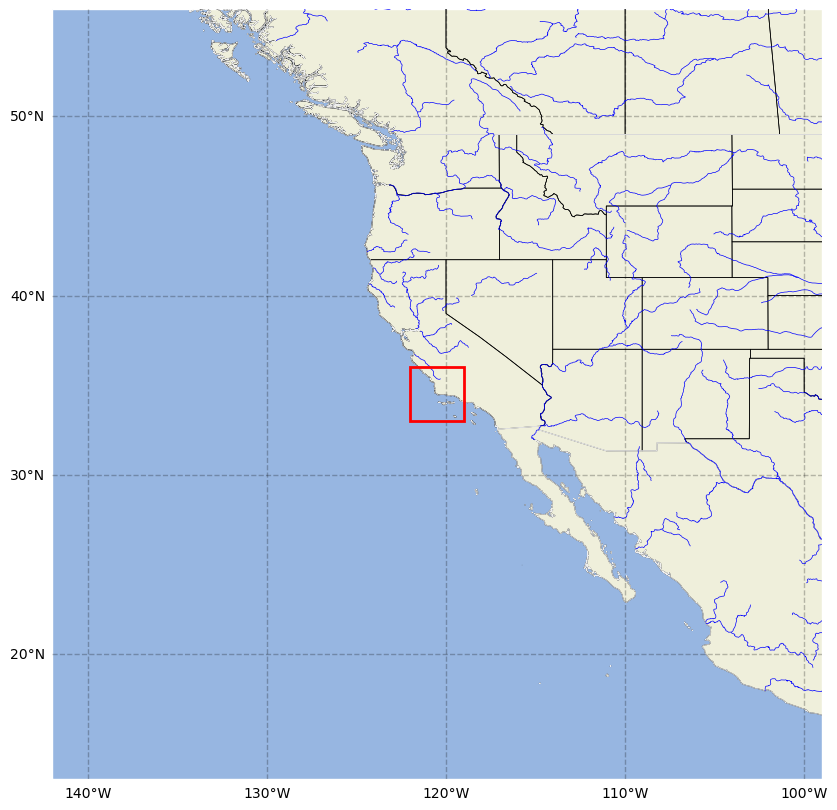

In [703]:
wildfires_bb = {'min_lon': -122, 'max_lon': -119, 'min_lat': 33, 'max_lat': 36}
wildfires_start_time = datetime(2020,8,1)
wildfires_end_time = datetime(2020,11,1)

wildfires_bbox = box(wildfires_bb['min_lon'], wildfires_bb['min_lat'], wildfires_bb['max_lon'], wildfires_bb['max_lat'])
plotting.map_box(wildfires_bb)

### Alisal Smoke Plume Visualization
On October 13, 2021, the Moderate Resolution Imaging Spectroradiometer (MODIS) on NASA’s Aqua satellite captured this image of the Alisal fire northwest of Santa Barbara. Strong northerly winds pushed plumes of smoke over the Pacific Ocean. 

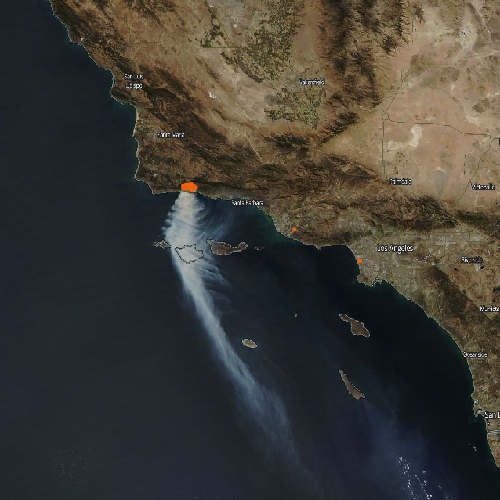

In [704]:
# Connect to GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

img = wms.getmap(layers=['BlueMarble_NextGeneration',
                         'MODIS_Aqua_CorrectedReflectance_TrueColor',
                         'MODIS_Aqua_Thermal_Anomalies_All',
                         'Reference_Features',
                         'Reference_Labels'],  # Layers
                 srs='epsg:4326',  # Map projection
                 bbox=(-122,32,-117,36),  # Bounds (min-lon, min-lat, max-lon, max-lat)
                 size=(500, 500),  # Image size
                 time='2021-10-12',  # Time of data
                 format='image/png',  # Image format
                 transparent=True)  # Nodata transparency

# View image
Image(img.read()) # NOTE add in rest of tropomi data, add a time lapse gif of the fire plume 

In [705]:
alisal_bb = {'min_lon': -120.559662, 'max_lon': -120.179261, 'min_lat': 34.308912, 'max_lat': 34.660953}
alisal_start_time = datetime(2021,10,1)
alisal_end_time = datetime(2021,11,20)

### NO2 Levels

Wildfires are a significant source of nitrogen oxides (NOx ≡ NO + NO2) to the global atmosphere, representing approximately 15% of the total NOx budget.

The graph below shows the NO2 output lifecycle of the Alisal wildfire (burned 10-11-2021 through 11-20-2021).

https://aq-sdap.stcenter.net/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-NO2&minLon=-120.559662&minLat=34.308912&maxLon=-120.179261&maxLat=34.660953&startTime=2021-10-01T00:00:00Z&endTime=2021-11-20T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 3.2601095319987508 seconds


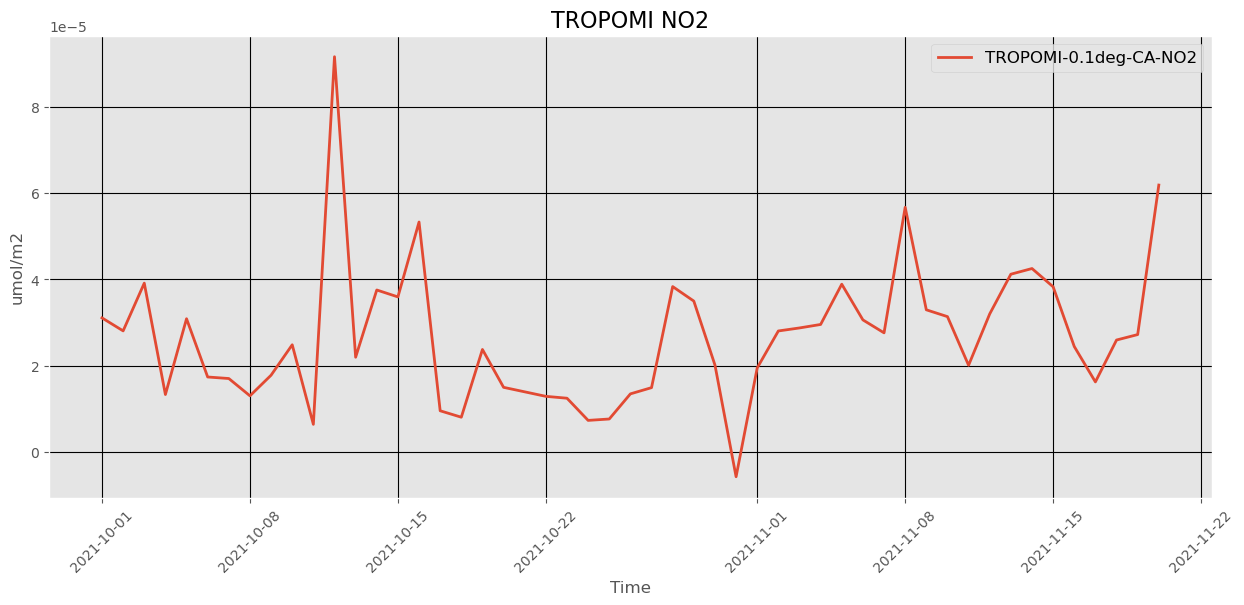

In [706]:
wildfires_omi_no2 = plotting.spatial_mean(gmu_base_url, 'TROPOMI-0.1deg-CA-NO2', alisal_bb, alisal_start_time, alisal_end_time)
plotting.comparison_plot([wildfires_omi_no2], 'Time', units['NO2'], var='TROPOMI NO2')

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//dailydifferenceaverage_spark?dataset=TROPOMI-0.1deg-CA-NO2&climatology=TROPOMI-0.1deg-CA-NO2_clim&b=-120.559662,34.308912,-120.179261,34.660953&startTime=2021-10-01T00:00:00Z&endTime=2021-11-20T00:00:00Z

Waiting for response from IDEAS... took 1.1843576469982509 seconds


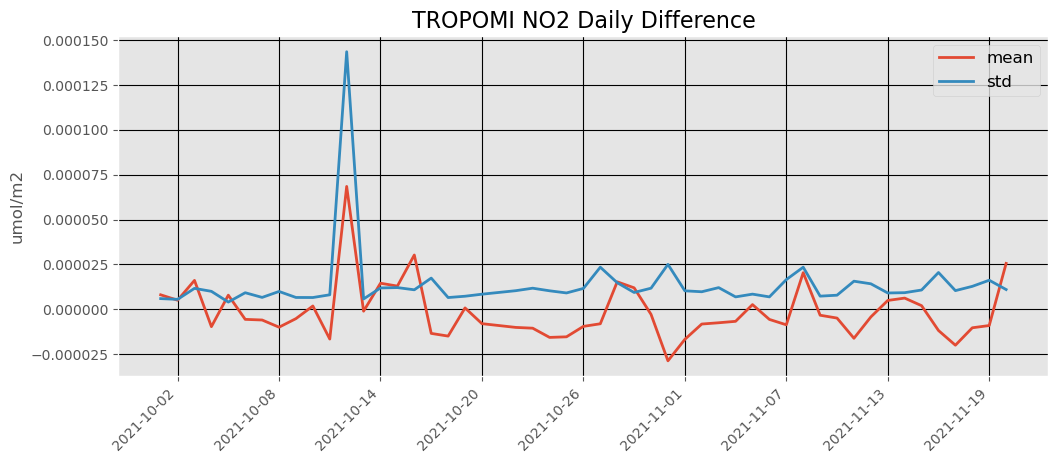

In [707]:
NO2_dataset  = 'TROPOMI-0.1deg-CA-NO2'
NO2_computed_climatology = 'TROPOMI-0.1deg-CA-NO2_clim'

NO2_daily_diff_data = ideas_processing.daily_diff(aq_base_url, NO2_dataset, NO2_computed_climatology, alisal_bb, alisal_start_time, alisal_end_time)
plotting.timeseries_plot([(NO2_daily_diff_data['mean'], 'mean'), (NO2_daily_diff_data['std'], 'std')], '', 'umol/m2', title='TROPOMI NO2 Daily Difference')

### O3 Levels

Wildfires harm the ozone layer by depleting Ozone levels putting us at an increased risk from ultraviolet (UV) radiation. 
Researchers caution that if major fires become more frequent with a changing climate, more damaging ultraviolet radiation from the sun will reach the ground.

https://aq-sdap.stcenter.net/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-O3&minLon=-120.559662&minLat=34.308912&maxLon=-120.179261&maxLat=34.660953&startTime=2021-10-01T00:00:00Z&endTime=2021-11-20T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 0.7762519730022177 seconds


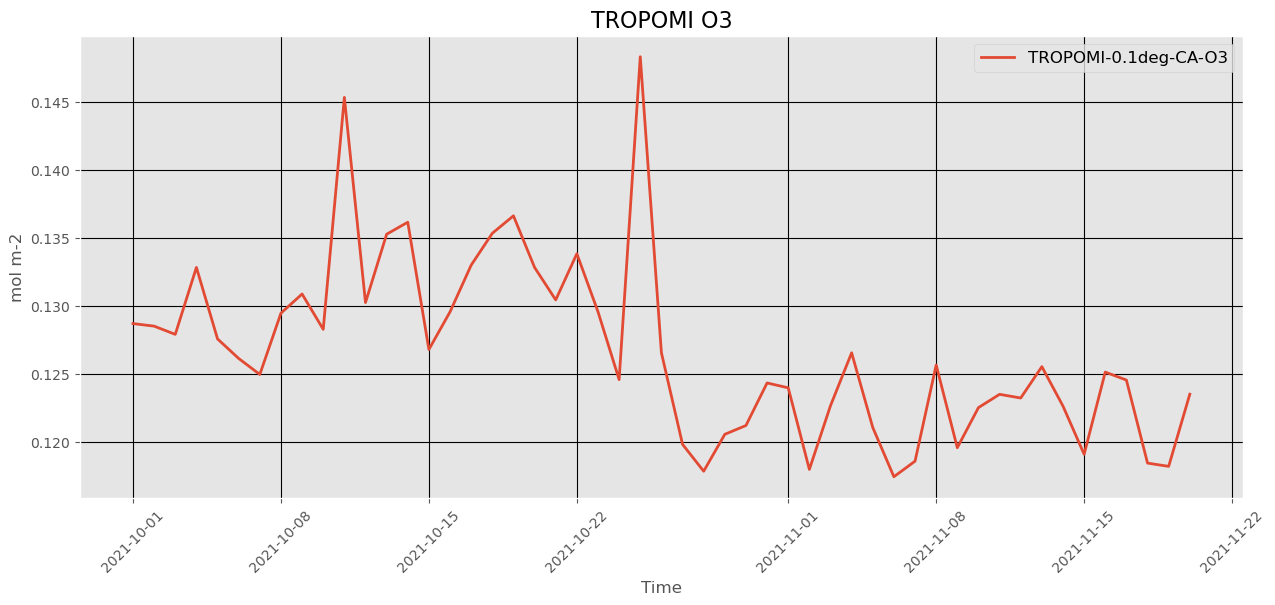

In [708]:
wildfires_omi_O3 = plotting.spatial_mean(gmu_base_url, 'TROPOMI-0.1deg-CA-O3', alisal_bb, alisal_start_time, alisal_end_time)
plotting.comparison_plot([wildfires_omi_O3], 'Time', units['O3'], var='TROPOMI O3')

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//dailydifferenceaverage_spark?dataset=TROPOMI-0.1deg-CA-O3&climatology=TROPOMI-0.1deg-CA-O3_clim&b=-120.559662,34.308912,-120.179261,34.660953&startTime=2021-10-01T00:00:00Z&endTime=2021-11-20T00:00:00Z

Waiting for response from IDEAS... took 1.2775662370040664 seconds


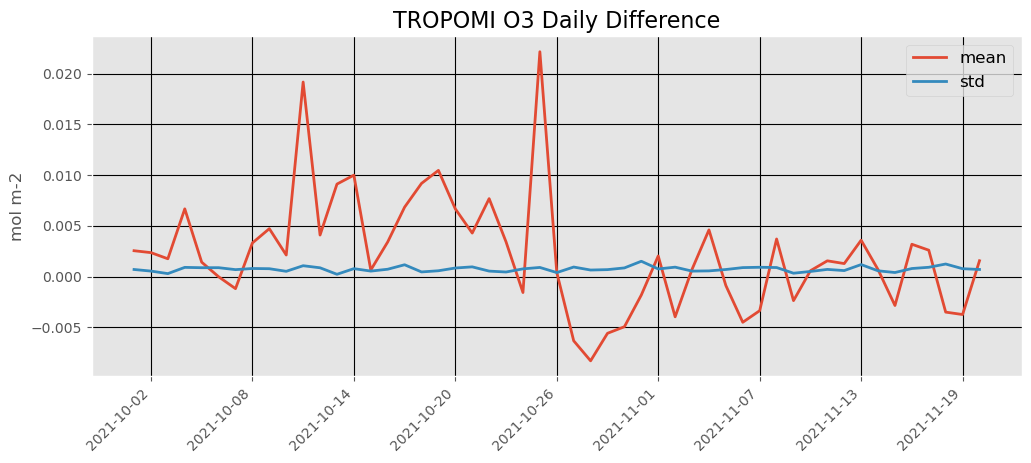

In [709]:
global_precipitation_dataset  = 'TROPOMI-0.1deg-CA-O3'
global_precipitation_computed_climatology = 'TROPOMI-0.1deg-CA-O3_clim'

pakistan_daily_diff_data = ideas_processing.daily_diff(aq_base_url, global_precipitation_dataset, global_precipitation_computed_climatology, alisal_bb, alisal_start_time, alisal_end_time)
plotting.timeseries_plot([(pakistan_daily_diff_data['mean'], 'mean'), (pakistan_daily_diff_data['std'], 'std')], '', 'mol m-2', title='TROPOMI O3 Daily Difference')

# NOTE change to 2021 california wildfires 

# 2021 California Wildfires 
The 2021 California wildfire season was one of the worst on record with about 2.5 million acres burned.
It's estimated that California wildfires emitted 75 million metric tons of carbon dioxide in just three months (June - August 2021).

75 million metric tons of carbon dioxide is equal to:
> - 16,310,993 passenger cars driven for a year (Greenhouse Gas - GHG)
> - 188,489,840,317 miles driven by an average passenger vehicle (GHG)
> - 8,439,293,350 gallons of gasoline consumed (Carbon Dioxide Emissions – CO2)
> - 82,896,993 pounds of coal burned (CO2)
> - 173,640,855 barrels of oil consumed (CO2)

### Area of Interest

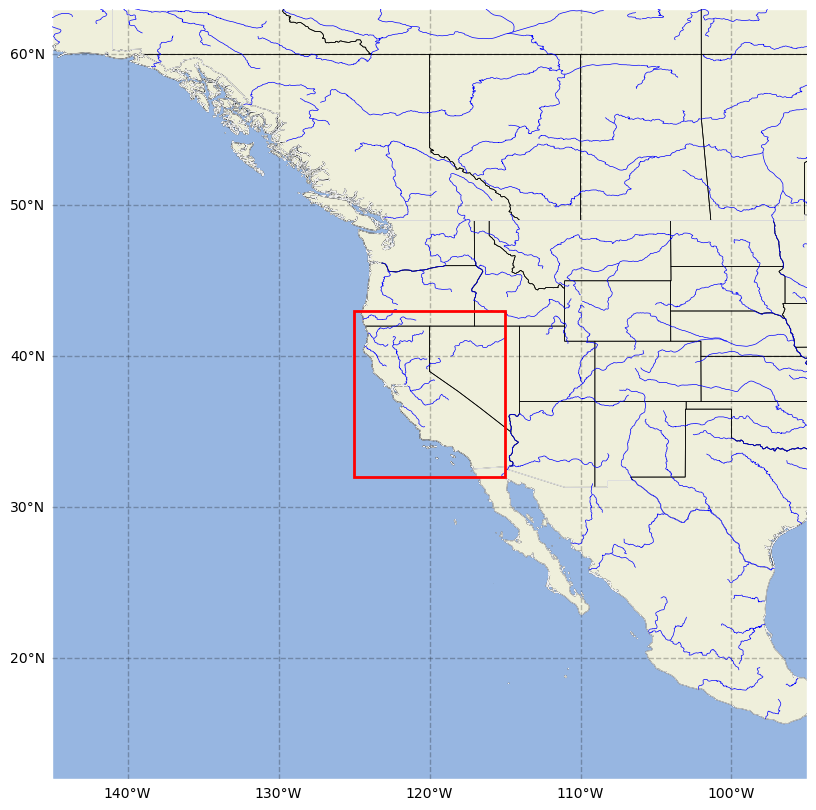

In [710]:
wildfires_bb = {'min_lon': -125, 'max_lon': -115, 'min_lat': 32, 'max_lat': 43}
wildfires_start_time = datetime(2021,4,1)
wildfires_end_time = datetime(2021,9,1)

wildfires_bbox = box(wildfires_bb['min_lon'], wildfires_bb['min_lat'], wildfires_bb['max_lon'], wildfires_bb['max_lat'])
plotting.map_box(wildfires_bb)


### SO2 Levels
Sulfur dioxide (SO2) is a foul-smelling toxic gas which can damage trees and plants, inhibit plant growth, and damage sensitive ecosystems and waterways. It also can contribute to respiratory illness and aggravate existing heart and lung conditions.

Additionally sulfur dioxide can create secondary pollutants, such as sulfate aerosols, particulate matter, and acid rain, once released into the air.

https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-SO2&minLon=-125&minLat=32&maxLon=-115&maxLat=43&startTime=2021-04-01T00:00:00Z&endTime=2021-09-01T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 1.6133110629962175 seconds


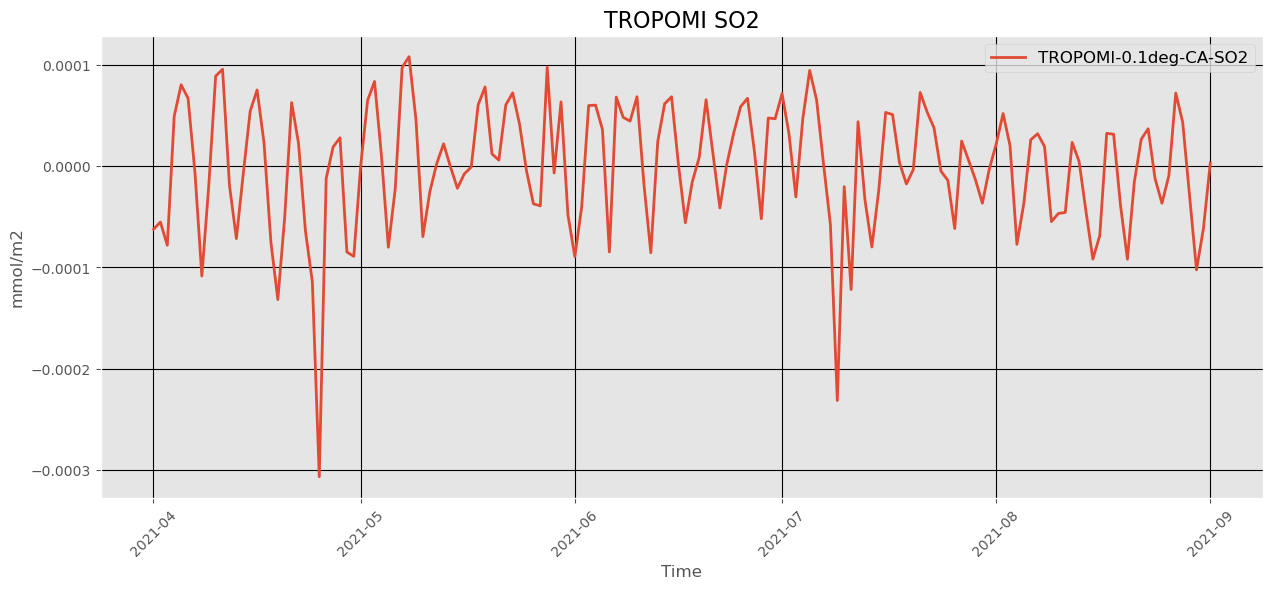

In [711]:
tropomi_so2 = plotting.spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-SO2', wildfires_bb, wildfires_start_time, wildfires_end_time)
plotting.comparison_plot([tropomi_so2], 'Time', units['SO2'], var='TROPOMI SO2')

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//dailydifferenceaverage_spark?dataset=TROPOMI-0.1deg-CA-SO2&climatology=TROPOMI-0.1deg-CA-SO2_clim&b=-125,32,-115,43&startTime=2021-04-01T00:00:00Z&endTime=2021-09-01T00:00:00Z

Waiting for response from IDEAS... took 6.444696804996056 seconds


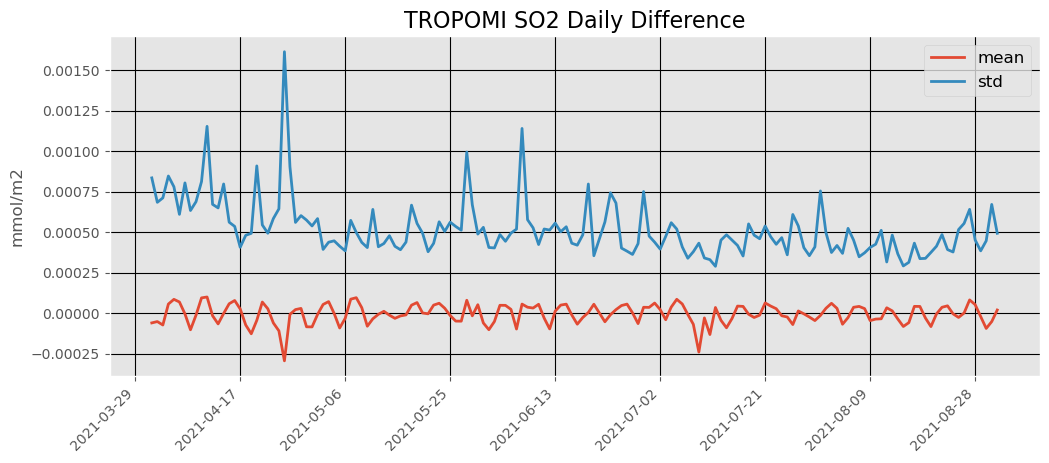

In [712]:
SO2_dataset  = 'TROPOMI-0.1deg-CA-SO2'
SO2_computed_climatology = 'TROPOMI-0.1deg-CA-SO2_clim'

pakistan_daily_diff_data = ideas_processing.daily_diff(aq_base_url, SO2_dataset, SO2_computed_climatology, wildfires_bb, wildfires_start_time, wildfires_end_time)
plotting.timeseries_plot([(pakistan_daily_diff_data['mean'], 'mean'), (pakistan_daily_diff_data['std'], 'std')], '', 'mmol/m2', title='TROPOMI SO2 Daily Difference')

### O3 Levels

https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-O3&minLon=-125&minLat=32&maxLon=-115&maxLat=43&startTime=2021-04-01T00:00:00Z&endTime=2021-09-01T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 1.33500715700211 seconds


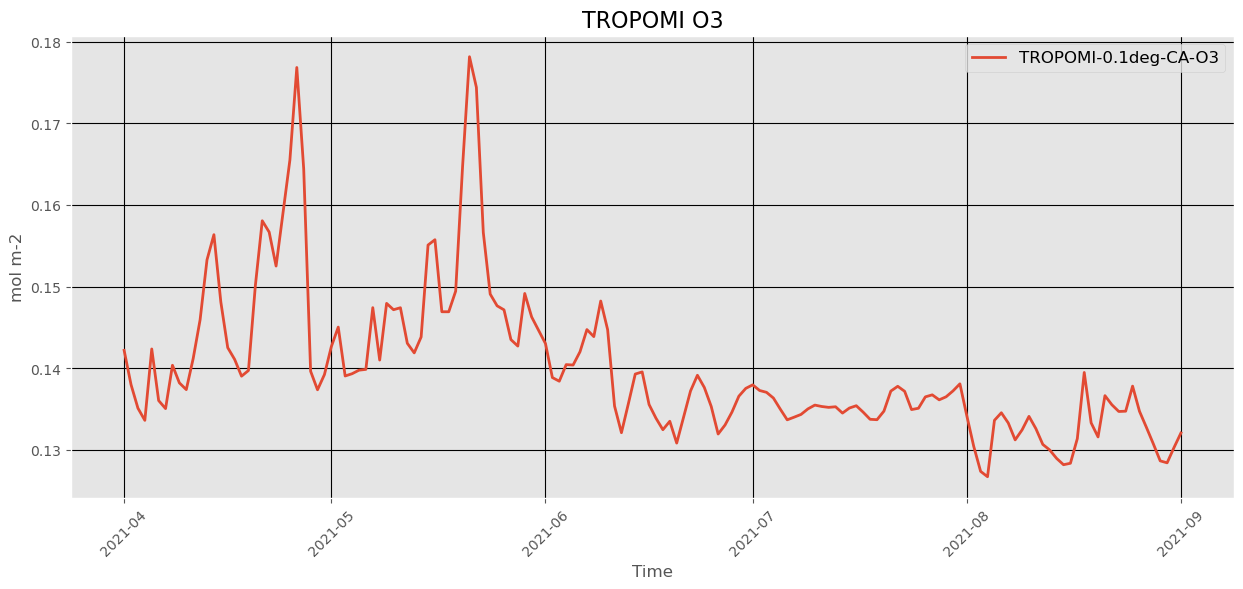

In [713]:
tropomi_o3 =  plotting.spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-O3', wildfires_bb, wildfires_start_time, wildfires_end_time)
plotting.comparison_plot([tropomi_o3], 'Time', units['O3'], var='TROPOMI O3')

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//dailydifferenceaverage_spark?dataset=TROPOMI-0.1deg-CA-O3&climatology=TROPOMI-0.1deg-CA-O3_clim&b=-125,32,-115,43&startTime=2021-04-01T00:00:00Z&endTime=2021-09-01T00:00:00Z

Waiting for response from IDEAS... took 6.200353184998676 seconds


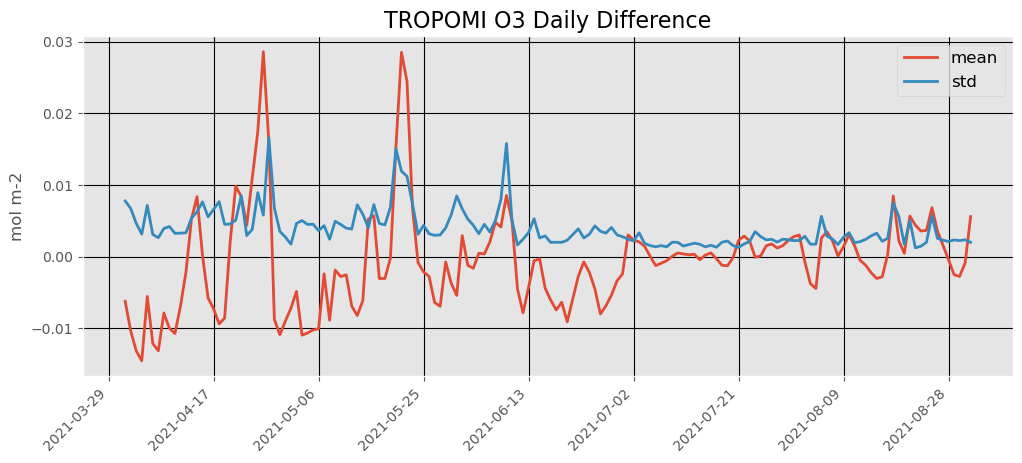

In [714]:
O3_dataset  = 'TROPOMI-0.1deg-CA-O3'
O3_computed_climatology = 'TROPOMI-0.1deg-CA-O3_clim'

wildfire_O3_daily_diff_data = ideas_processing.daily_diff(aq_base_url, O3_dataset, O3_computed_climatology, wildfires_bb, wildfires_start_time, wildfires_end_time)
plotting.timeseries_plot([(wildfire_O3_daily_diff_data['mean'], 'mean'), (wildfire_O3_daily_diff_data['std'], 'std')], '', 'mol m-2', title='TROPOMI O3 Daily Difference')

### NO2 Levels

https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-NO2&minLon=-125&minLat=32&maxLon=-115&maxLat=43&startTime=2021-04-01T00:00:00Z&endTime=2021-09-01T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 0.6614100340011646 seconds


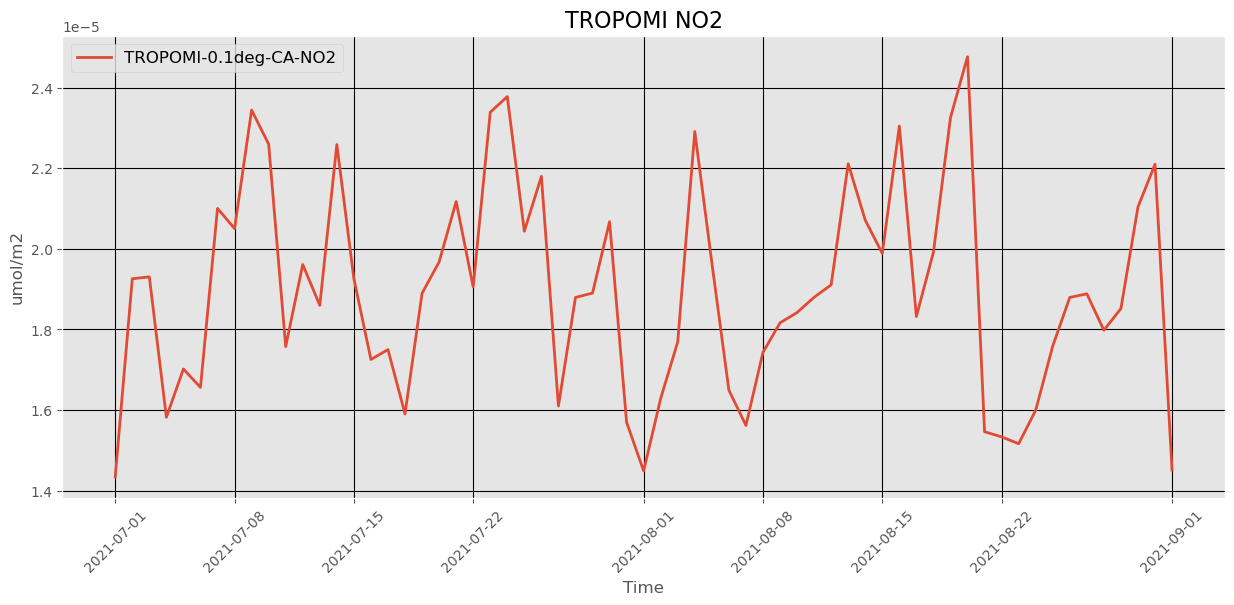

In [715]:
wildfires_omi_no2 = plotting.spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-NO2', wildfires_bb, wildfires_start_time, wildfires_end_time)
plotting.comparison_plot([wildfires_omi_no2], 'Time', units['NO2'], var='TROPOMI NO2')

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//dailydifferenceaverage_spark?dataset=TROPOMI-0.1deg-CA-NO2&climatology=TROPOMI-0.1deg-CA-NO2_clim&b=-125,32,-115,43&startTime=2021-04-01T00:00:00Z&endTime=2021-09-01T00:00:00Z

Waiting for response from IDEAS... took 2.974254528002348 seconds


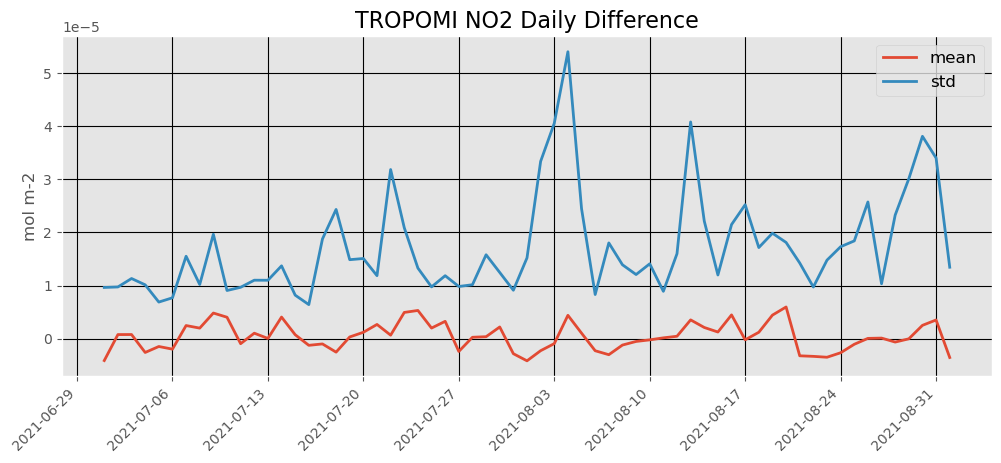

In [716]:
O3_dataset  = 'TROPOMI-0.1deg-CA-NO2'
O3_computed_climatology = 'TROPOMI-0.1deg-CA-NO2_clim'

wildfire_O3_daily_diff_data = ideas_processing.daily_diff(aq_base_url, O3_dataset, O3_computed_climatology, wildfires_bb, wildfires_start_time, wildfires_end_time)
plotting.timeseries_plot([(wildfire_O3_daily_diff_data['mean'], 'mean'), (wildfire_O3_daily_diff_data['std'], 'std')], '', 'mol m-2', title='TROPOMI NO2 Daily Difference')

### SO2 Temporal Variance

https://ideas-digitaltwin.jpl.nasa.gov/nexus//varianceSpark?ds=TROPOMI-0.1deg-CA-SO2&minLon=-125&minLat=32&maxLon=-115&maxLat=43&startTime=2021-04-01T00:00:00Z&endTime=2021-09-01T00:00:00Z

Waiting for response from SDAP...
Time series took 4.5377244310002425 seconds


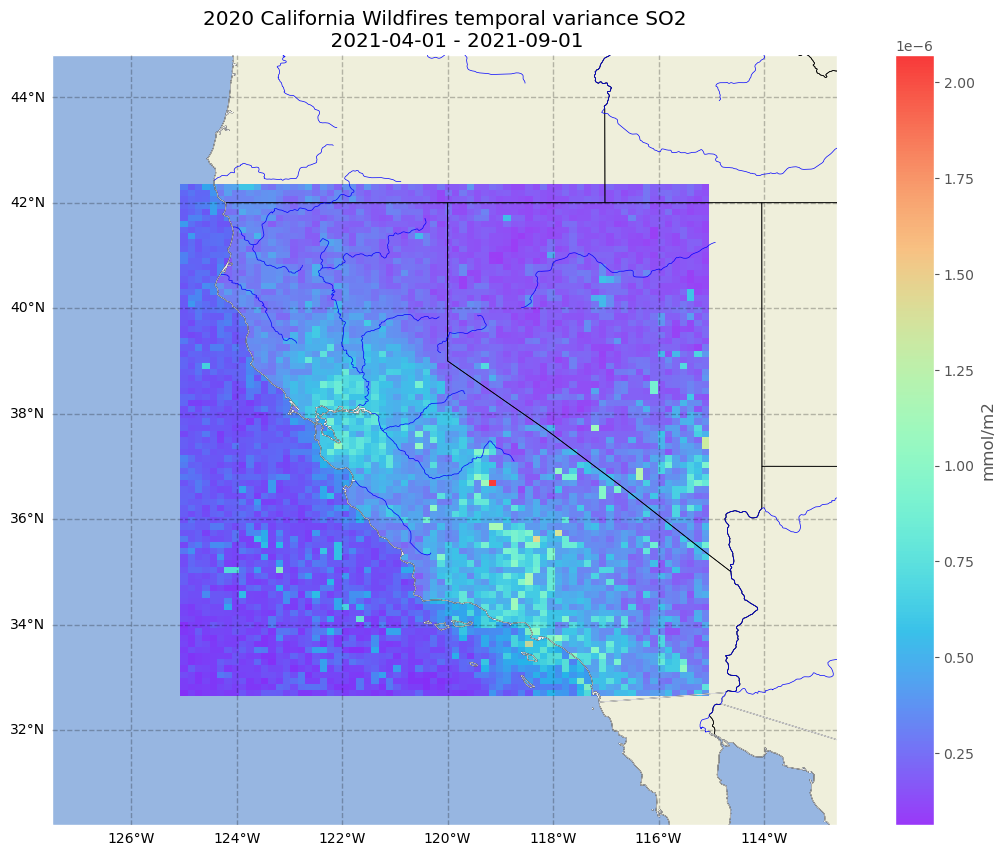

In [717]:
wildfires_temp_var_tropomi_so2 = plotting.temporal_variance(aq_base_url, 'TROPOMI-0.1deg-CA-SO2', wildfires_bb, wildfires_start_time, wildfires_end_time)

wildfire_variance_title = f'2020 California Wildfires temporal variance SO2\n\
    {str(wildfires_start_time)[:10]} - {str(wildfires_end_time)[:10]}'
plotting.map_data(wildfires_temp_var_tropomi_so2, wildfire_variance_title, cb_label=units['SO2'])

### O3 Temporal Variance

https://ideas-digitaltwin.jpl.nasa.gov/nexus//varianceSpark?ds=TROPOMI-0.1deg-CA-NO2&minLon=-125&minLat=32&maxLon=-115&maxLat=43&startTime=2021-04-01T00:00:00Z&endTime=2021-09-01T00:00:00Z

Waiting for response from SDAP...
Time series took 3.5488686180033255 seconds


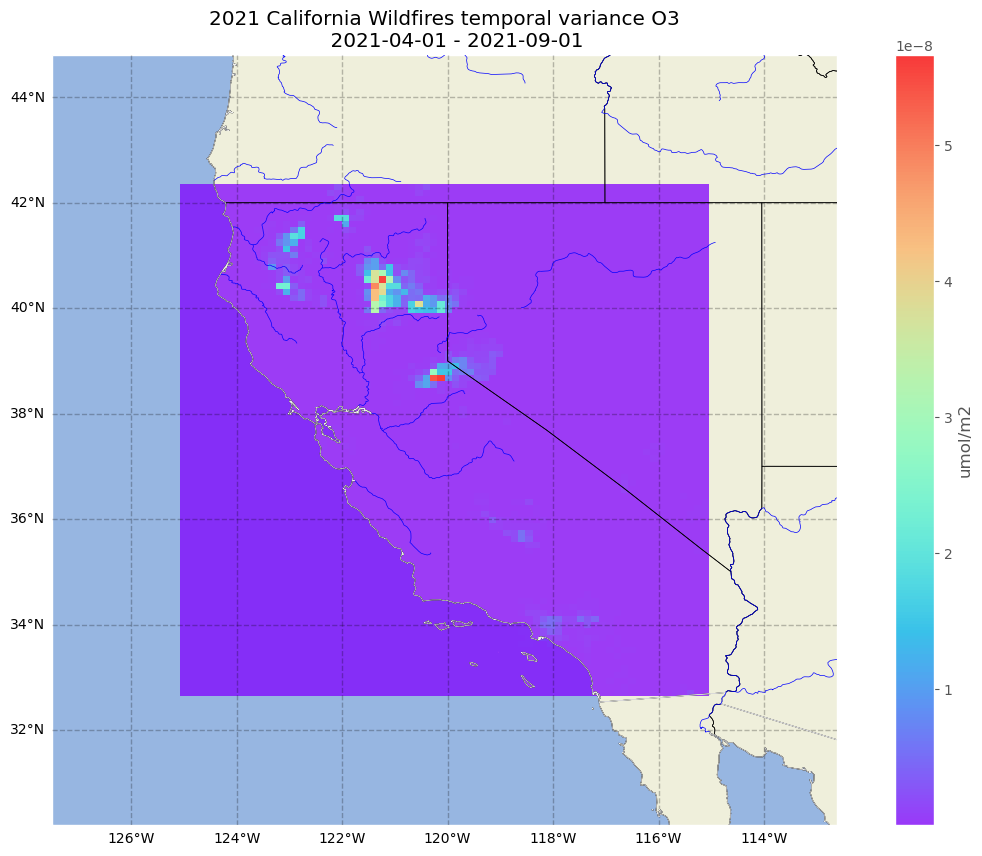

In [718]:
wildfires_temp_var_tropomi_o3 = plotting.temporal_variance(aq_base_url, 'TROPOMI-0.1deg-CA-NO2', wildfires_bb, wildfires_start_time, wildfires_end_time)

wildfire_variance_title = f'2021 California Wildfires temporal variance O3\n\
    {str(wildfires_start_time)[:10]} - {str(wildfires_end_time)[:10]}'
plotting.map_data(wildfires_temp_var_tropomi_o3, wildfire_variance_title, cb_label=units['NO2'])

# Los Angeles ports backlog Fall 2021
Beginning around October 2021, the Ports of Los Angeles and Long Beach started suffering serious backlogs of ships due a surge in e-commerence because of the COVID-19 pandemic. This resulted in many ships anchored in the ports and releasing high amounts of pollutants. 

### Area of interest

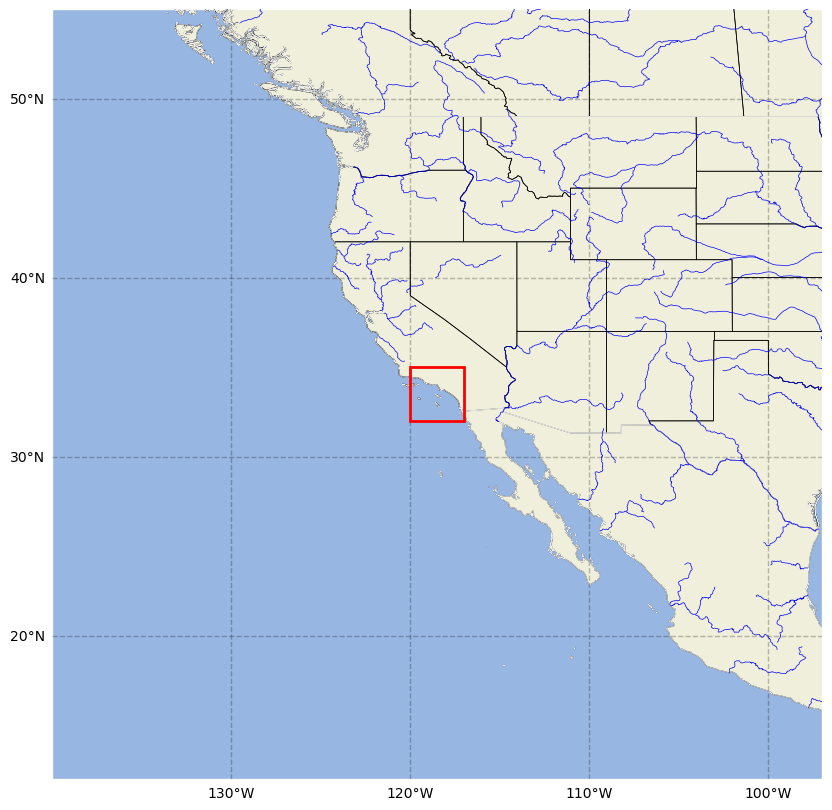

In [719]:
la_ports_bb = {
    'min_lon': -120,
    'max_lon': -117,
    'min_lat': 32,
    'max_lat': 35
}
la_ports_basemap_range = {
    'llcrnrlon': -140,
    'llcrnrlat': 0,
    'urcrnrlon': -90,
    'urcrnrlat': 60
}

la_ports_start_time = datetime(2021,10,1)
la_ports_end_time = datetime(2021,12,31)

la_ports_bbox = box(la_ports_bb['min_lon'], la_ports_bb['min_lat'], la_ports_bb['max_lon'], la_ports_bb['max_lat'])
plotting.map_box(la_ports_bb)

### SO2 Levels

https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-SO2&minLon=-120&minLat=32&maxLon=-117&maxLat=35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 0.4995716880002874 seconds


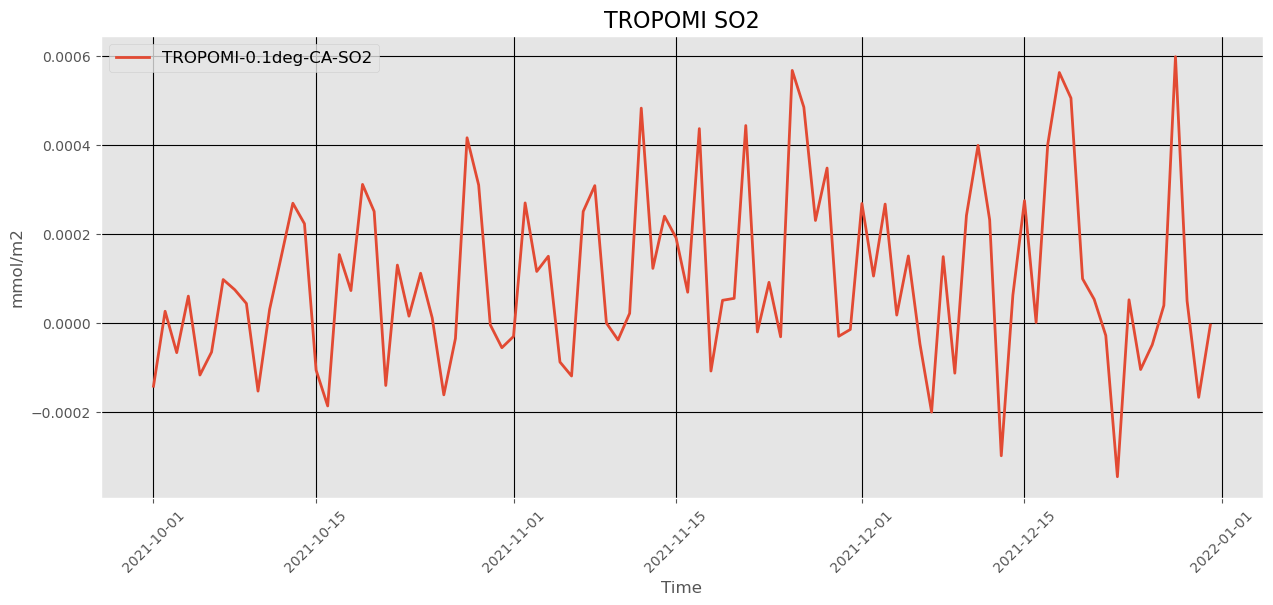

In [720]:
la_ports_tropomi_so2 = plotting.spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-SO2', la_ports_bb, la_ports_start_time, la_ports_end_time)
plotting.comparison_plot([la_ports_tropomi_so2], 'Time', units['SO2'], var='TROPOMI SO2')

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//dailydifferenceaverage_spark?dataset=TROPOMI-0.1deg-CA-SO2&climatology=TROPOMI-0.1deg-CA-SO2_clim&b=-120,32,-117,35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z

Waiting for response from IDEAS... took 2.3327612889988814 seconds


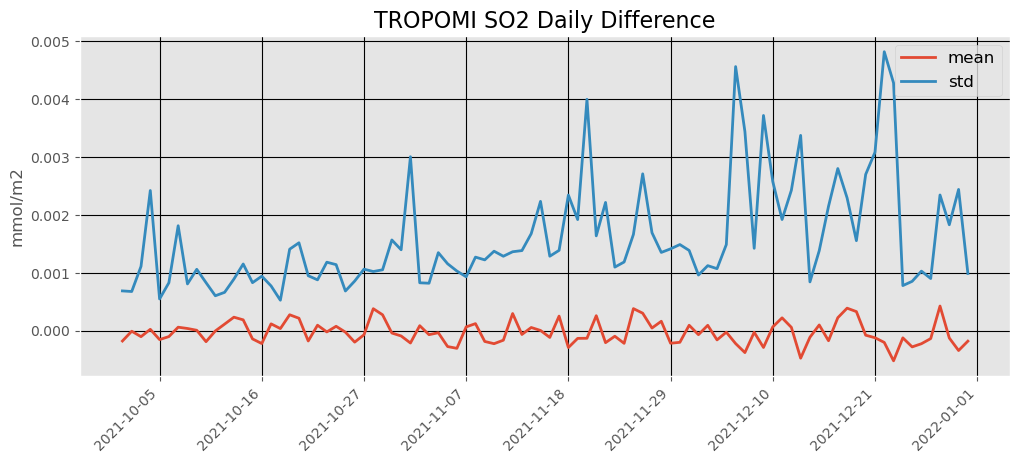

In [721]:
SO2_dataset  = 'TROPOMI-0.1deg-CA-SO2'
SO2_computed_climatology = 'TROPOMI-0.1deg-CA-SO2_clim'

la_ports_SO2_daily_diff_data = ideas_processing.daily_diff(aq_base_url, SO2_dataset, SO2_computed_climatology, la_ports_bb, la_ports_start_time, la_ports_end_time)
plotting.timeseries_plot([(la_ports_SO2_daily_diff_data['mean'], 'mean'), (la_ports_SO2_daily_diff_data['std'], 'std')], '', 'mmol/m2', title='TROPOMI SO2 Daily Difference')

### O3 Levels

https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-O3&minLon=-120&minLat=32&maxLon=-117&maxLat=35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 0.4674445389973698 seconds


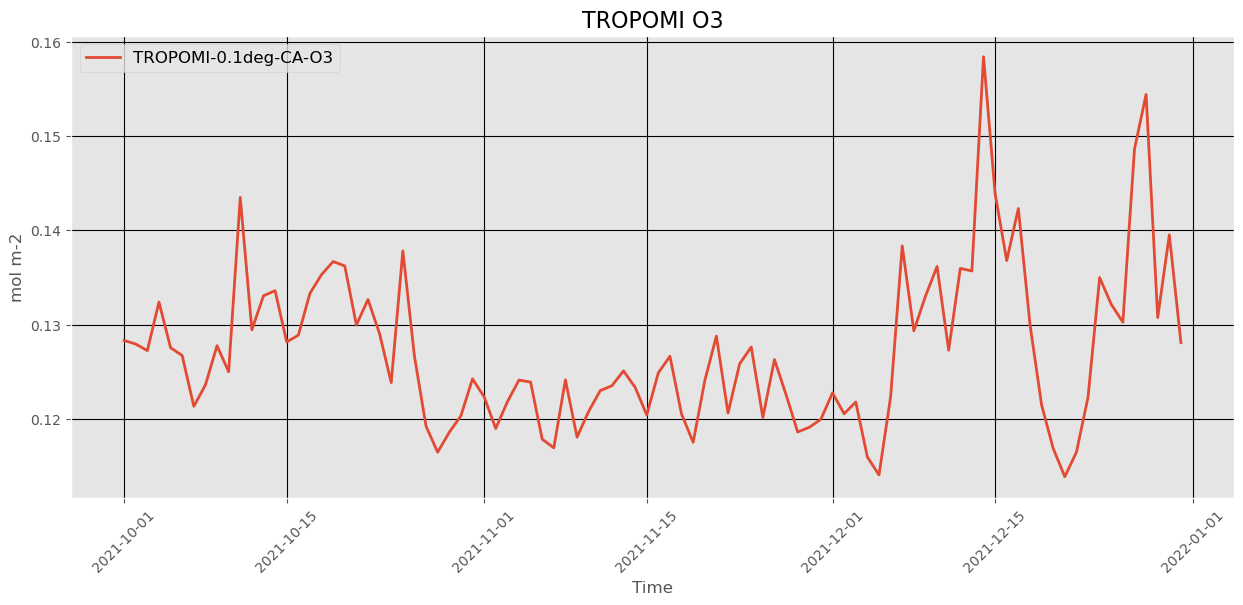

In [722]:
tropomi_o3 = plotting.spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-O3', la_ports_bb, la_ports_start_time, la_ports_end_time)
plotting.comparison_plot([tropomi_o3], 'Time', units['O3'], var='TROPOMI O3')

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//dailydifferenceaverage_spark?dataset=TROPOMI-0.1deg-CA-O3&climatology=TROPOMI-0.1deg-CA-O3_clim&b=-120,32,-117,35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z

Waiting for response from IDEAS... took 1.3671959470011643 seconds


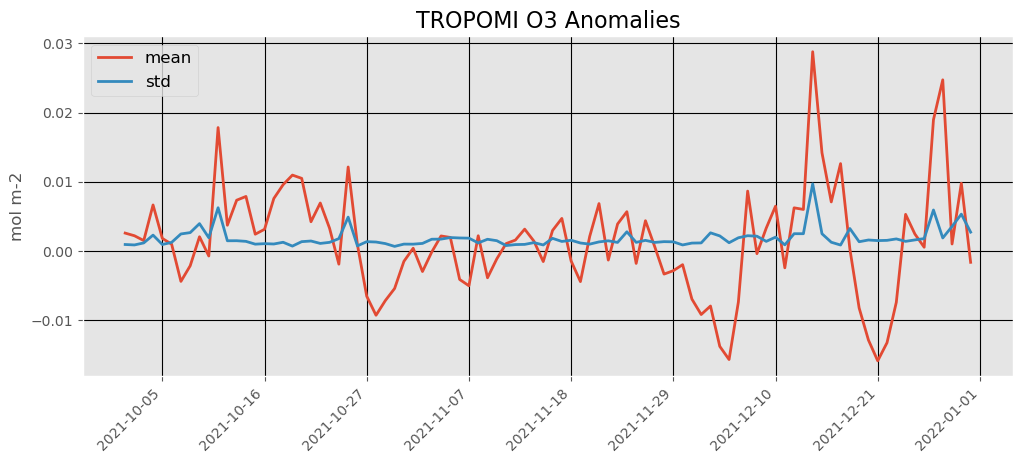

In [723]:
O3_dataset  = 'TROPOMI-0.1deg-CA-O3'
O3_computed_climatology = 'TROPOMI-0.1deg-CA-O3_clim'

la_ports_O3_daily_diff_data = ideas_processing.daily_diff(aq_base_url, O3_dataset, O3_computed_climatology, la_ports_bb, la_ports_start_time, la_ports_end_time)
plotting.timeseries_plot([(la_ports_O3_daily_diff_data['mean'], 'mean'), (la_ports_O3_daily_diff_data['std'], 'std')], '', 'mol m-2', title='TROPOMI O3 Anomalies')

### NO2 Levels

https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-NO2&minLon=-120&minLat=32&maxLon=-117&maxLat=35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 0.3448816110030748 seconds


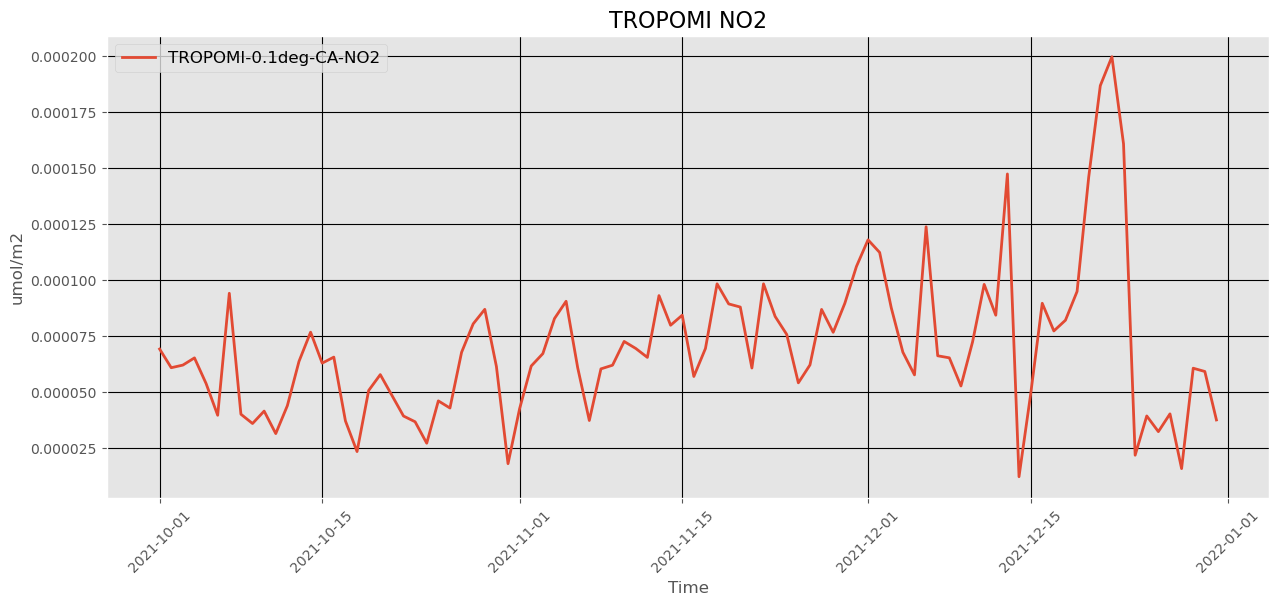

In [724]:
tropomi_no2 = plotting.spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-NO2', la_ports_bb, la_ports_start_time, la_ports_end_time)
plotting.comparison_plot([tropomi_no2], 'Time', units['NO2'], var='TROPOMI NO2')

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//dailydifferenceaverage_spark?dataset=TROPOMI-0.1deg-CA-NO2&climatology=TROPOMI-0.1deg-CA-NO2_clim&b=-120,32,-117,35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z

Waiting for response from IDEAS... took 1.2585274179946282 seconds


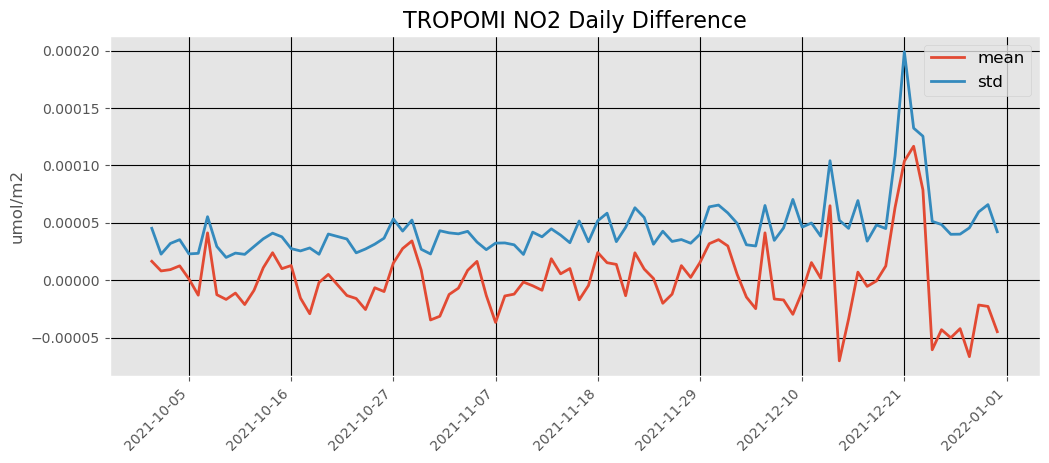

In [725]:
NO2_dataset  = 'TROPOMI-0.1deg-CA-NO2'
NO2_computed_climatology = 'TROPOMI-0.1deg-CA-NO2_clim'

la_ports_NO2_daily_diff_data = ideas_processing.daily_diff(aq_base_url, NO2_dataset, NO2_computed_climatology, la_ports_bb, la_ports_start_time, la_ports_end_time)
plotting.timeseries_plot([(la_ports_NO2_daily_diff_data['mean'], 'mean'), (la_ports_NO2_daily_diff_data['std'], 'std')], '', 'umol/m2', title='TROPOMI NO2 Daily Difference')

### CO Levels

https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-CO&minLon=-120&minLat=32&maxLon=-117&maxLat=35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 0.42260673599957954 seconds


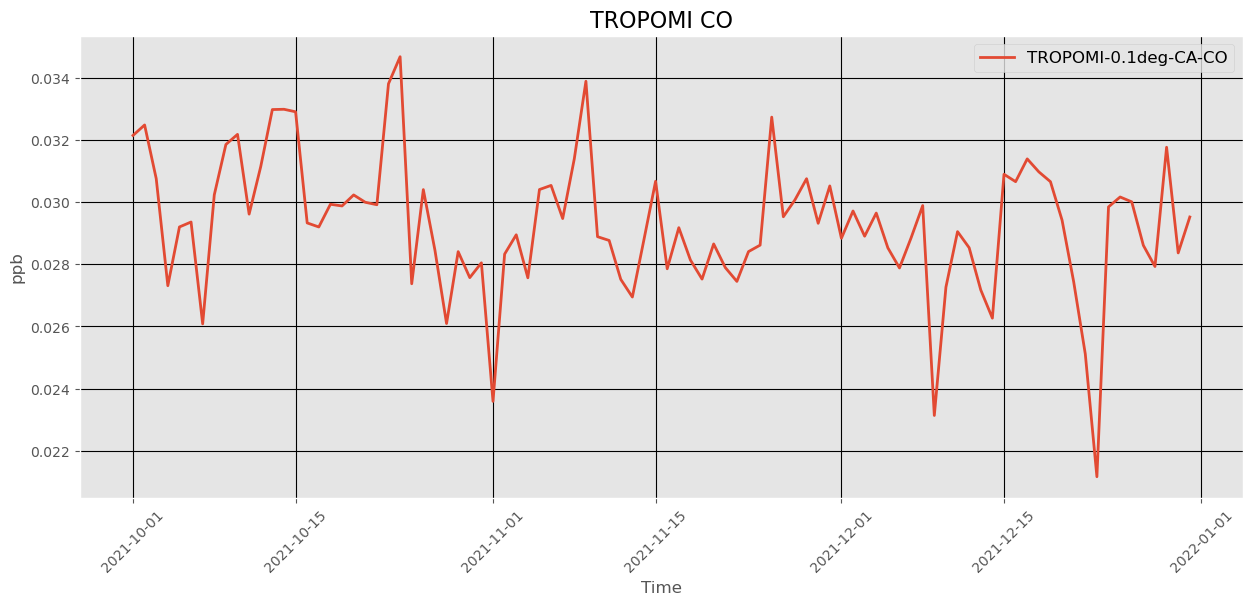

In [726]:
tropomi_co = plotting.spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-CO', la_ports_bb, la_ports_start_time, la_ports_end_time)
plotting.comparison_plot([tropomi_co], 'Time', units['CO'], var='TROPOMI CO')

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//dailydifferenceaverage_spark?dataset=TROPOMI-0.1deg-CA-CO&climatology=TROPOMI-0.1deg-CA-CO_clim&b=-120,32,-117,35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z

Waiting for response from IDEAS... took 1.306696979998378 seconds


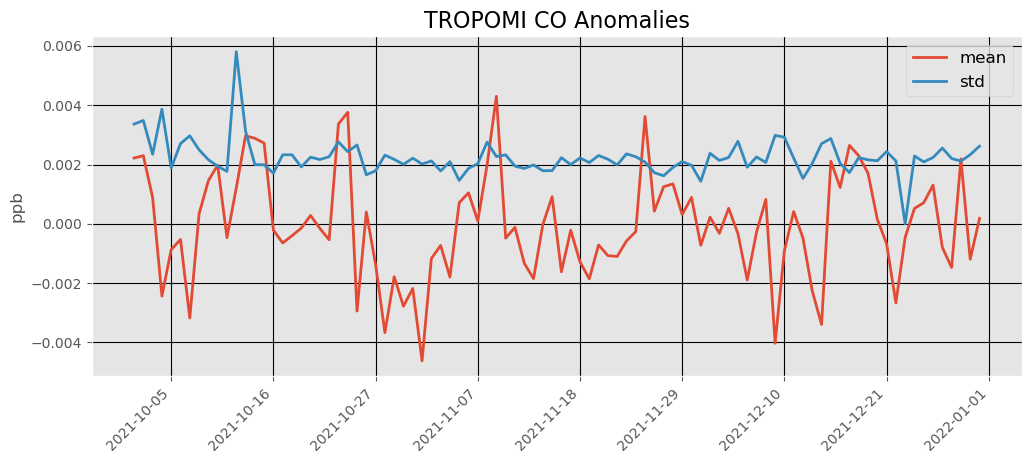

In [727]:
CO_dataset  = 'TROPOMI-0.1deg-CA-CO'
CO_computed_climatology = 'TROPOMI-0.1deg-CA-CO_clim'

la_ports_CO_daily_diff_data = ideas_processing.daily_diff(aq_base_url, CO_dataset, CO_computed_climatology, la_ports_bb, la_ports_start_time, la_ports_end_time)
plotting.timeseries_plot([(la_ports_CO_daily_diff_data['mean'], 'mean'), (la_ports_CO_daily_diff_data['std'], 'std')], '', 'ppb', title='TROPOMI CO Anomalies')

### CH4 Levels

Ships use methane (CH4) in the form of liquified natural gas. Remote marine air-quality measurements have shown significant methane emissions from ships using liquefied natural gas as a fuel.

https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-CH4&minLon=-120&minLat=32&maxLon=-117&maxLat=35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 0.3798226689978037 seconds


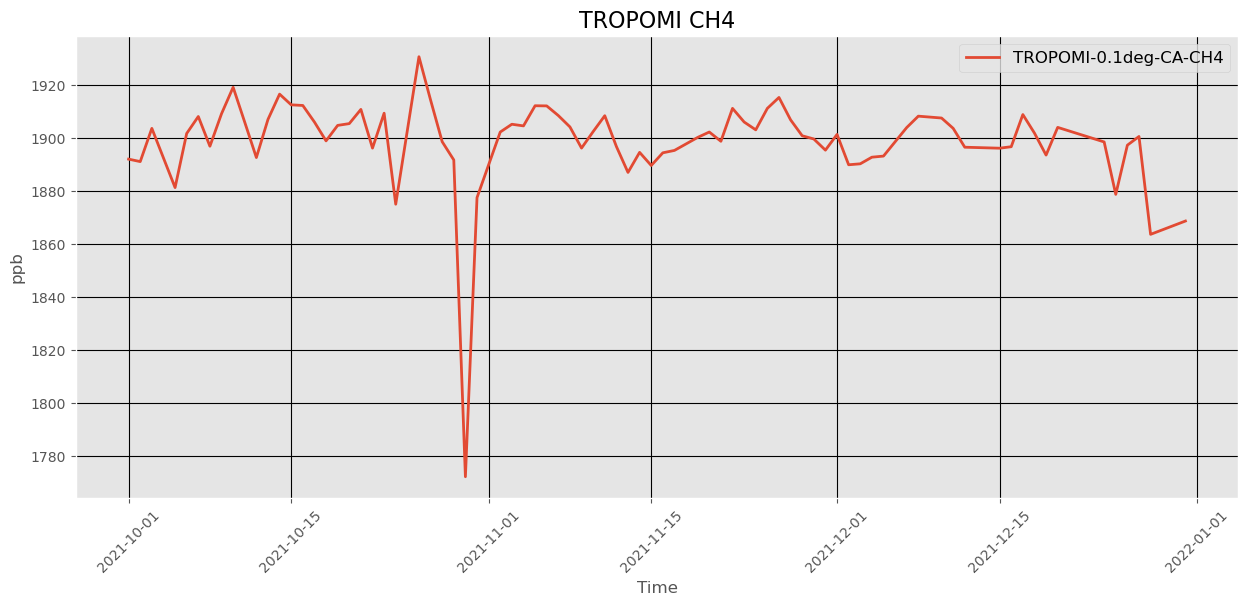

In [728]:
tropomi_ch4 = plotting.spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-CH4', la_ports_bb, la_ports_start_time, la_ports_end_time)
plotting.comparison_plot([tropomi_ch4], 'Time', units['CH4'], var='TROPOMI CH4')

url
 https://ideas-digitaltwin.jpl.nasa.gov/nexus//dailydifferenceaverage_spark?dataset=TROPOMI-0.1deg-CA-CH4&climatology=TROPOMI-0.1deg-CA-CH4_clim&b=-120,32,-117,35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z

Waiting for response from IDEAS... took 1.3908201600061147 seconds


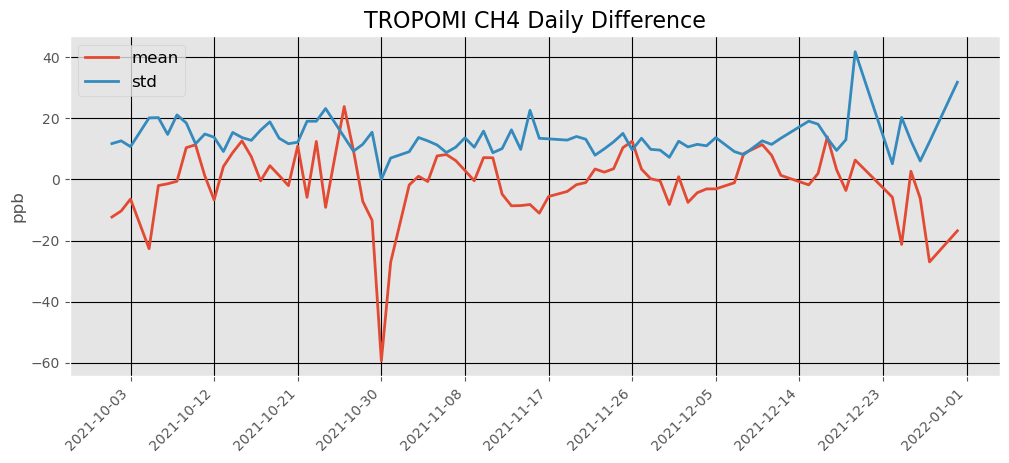

In [729]:
CH4_dataset  = 'TROPOMI-0.1deg-CA-CH4'
CH4_computed_climatology = 'TROPOMI-0.1deg-CA-CH4_clim'

la_ports_CH4_daily_diff_data = ideas_processing.daily_diff(aq_base_url, CH4_dataset, CH4_computed_climatology, la_ports_bb, la_ports_start_time, la_ports_end_time)
plotting.timeseries_plot([(la_ports_CH4_daily_diff_data['mean'], 'mean'), (la_ports_CH4_daily_diff_data['std'], 'std')], '', 'ppb', title='TROPOMI CH4 Daily Difference')

# Fireworks during 4th of July 2022 in Los Angeles County
Despite fireworks being outlawed for personal use in Los Angeles County, there is a significant amount of illegal fireworks displays in the area around 4th of July that cause very smoggy conditions.  
Below we model our in situ Particulate matter 2.5 and Black Carbon data from around 4th of July 

### Area of Interest

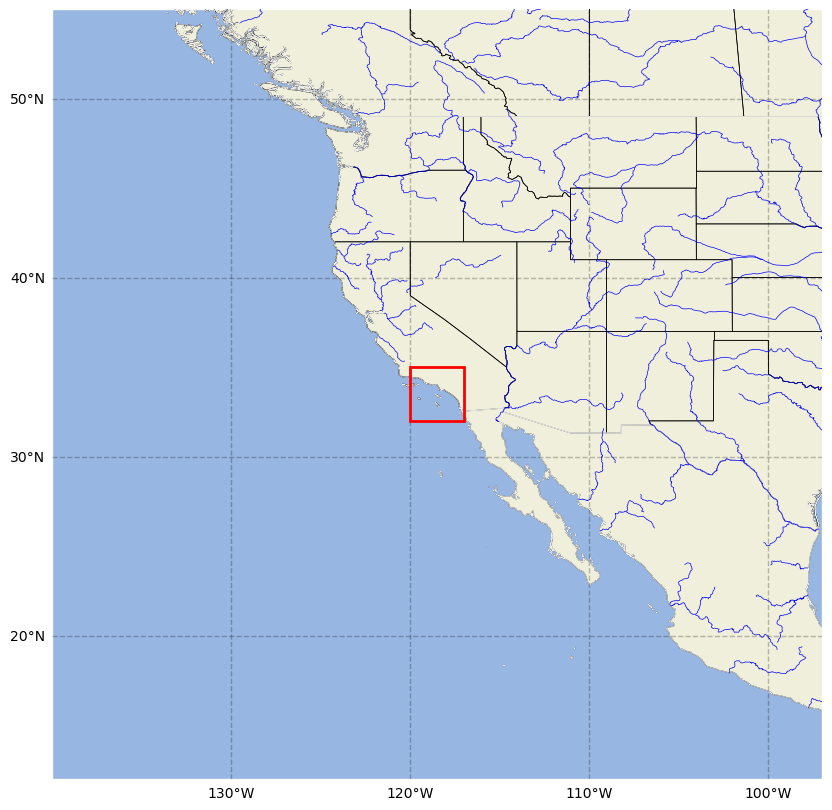

In [730]:
la_ports_bbox = box(la_ports_bb['min_lon'], la_ports_bb['min_lat'], la_ports_bb['max_lon'], la_ports_bb['max_lat'])
plotting.map_box(la_ports_bb)

### Get PM 2.5 and Black Carbon (BC) from B301 GRIMM Aethalometer (2021-06-28 to 2021-07-11)

In [731]:
start_time_fireworks      = '2021-06-28T00:00:00Z'
end_time_fireworks        = '2021-07-11T00:00:00Z'
min_lon_fireworks         = -120
max_lon_fireworks         = -115
min_lat_fireworks         = 30
max_lat_fireworks         = 40
provider_fireworks        = 'B301-GRIMM-Aethalometer'

pm25_bc_2021_fireworks  = plotting.get_in_situ_data(start_time_fireworks, end_time_fireworks,
                        min_lon_fireworks, max_lon_fireworks, min_lat_fireworks, max_lat_fireworks, provider_fireworks)
pm25_bc_2021_fireworks 

https://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/query_data_doms?startIndex=0&itemsPerPage=500&startTime=2021-06-28T00:00:00Z&endTime=2021-07-11T00:00:00Z&bbox=-120,30,-115,40&provider=B301-GRIMM-Aethalometer


provider                  time  latitude  longitude  site  \
0    B301-GRIMM-Aethalometer  2021-06-28T00:00:00Z   34.2013  -118.1714  None   
1    B301-GRIMM-Aethalometer  2021-06-28T01:00:00Z   34.2013  -118.1714  None   
2    B301-GRIMM-Aethalometer  2021-06-28T02:00:00Z   34.2013  -118.1714  None   
3    B301-GRIMM-Aethalometer  2021-06-28T03:00:00Z   34.2013  -118.1714  None   
4    B301-GRIMM-Aethalometer  2021-06-28T04:00:00Z   34.2013  -118.1714  None   
..                       ...                   ...       ...        ...   ...   
305  B301-GRIMM-Aethalometer  2021-07-10T20:00:00Z   34.2013  -118.1714  None   
306  B301-GRIMM-Aethalometer  2021-07-10T21:00:00Z   34.2013  -118.1714  None   
307  B301-GRIMM-Aethalometer  2021-07-10T22:00:00Z   34.2013  -118.1714  None   
308  B301-GRIMM-Aethalometer  2021-07-10T23:00:00Z   34.2013  -118.1714  None   
309  B301-GRIMM-Aethalometer  2021-07-11T00:00:00Z   34.2013  -118.1714  None   

         pm2_5        bc   no2    co   co2  ...  \
0    11.362640  0.757350  None  None  None  ...   
1    14.981810  0.713367  None  None  None  ...   
2    15.210835  0.805733  None  None  None  ...   
3    15.090975  0.844900  None  None  None  ...   
4    13.934720  0.793133  None  None  None  ...   
..         ...       ...   ...   ...   ...  ...   
305  10.701110  0.731567  None  None  None  ...   
306  10.899160  0.801967  None  None  None  ...   
307  11.520140  0.916000  None  None  None  ...   
308  11.639300  0.823983  None  None  None  ...   
309  11.430140  0.848750  None  None  None  ...   

    Stream_water_level_elevation_above_NAVD_1988_quality  \
0                                                 None     
1                                                 None     
2                                                 None     
3                                                 None     
4                                                 None     
..                                                 ...     
305                                               None     
306                                               None     
307                                               None     
308                                               None     
309                                               None     

    Lake_or_reservoir_water_surface_elevation_above_NAVD_1988_quality  \
0                                                 None                  
1                                                 None                  
2                                                 None                  
3                                                 None                  
4                                                 None                  
..                                                 ...                  
305                                               None                  
306                                               None                  
307                                               None                  
308                                               None                  
309                                               None                  

    Temperature_quality Specific_conductance_quality Turbidity_quality  \
0                  None                         None              None   
1                  None                         None              None   
2                  None                         None              None   
3                  None                         None              None   
4                  None                         None              None   
..                  ...                          ...               ...   
305                None                         None              None   
306                None                         None              None   
307                None                         None              None   
308                None                         None              None   
309                Non

### Get PM 2.5 and Black Carbon (BC) from B301 GRIMM Aethalometer (2022-06-28 to 2022-07-11)

In [732]:
start_time_fireworks      = '2022-06-28T00:00:00Z'
end_time_fireworks        = '2022-07-11T00:00:00Z'
min_lon_fireworks         = -120
max_lon_fireworks         = -115
min_lat_fireworks         = 30
max_lat_fireworks         = 40
provider_fireworks        = 'B301-GRIMM-Aethalometer'

pm25_bc_2022_fireworks  = plotting.get_in_situ_data(start_time_fireworks, end_time_fireworks,
                        min_lon_fireworks, max_lon_fireworks, min_lat_fireworks, max_lat_fireworks, provider_fireworks)
pm25_bc_2022_fireworks 

https://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/query_data_doms?startIndex=0&itemsPerPage=500&startTime=2022-06-28T00:00:00Z&endTime=2022-07-11T00:00:00Z&bbox=-120,30,-115,40&provider=B301-GRIMM-Aethalometer


provider                  time  latitude  longitude  site  \
0    B301-GRIMM-Aethalometer  2022-06-28T00:00:00Z   34.2013  -118.1714  None   
1    B301-GRIMM-Aethalometer  2022-06-28T01:00:00Z   34.2013  -118.1714  None   
2    B301-GRIMM-Aethalometer  2022-06-28T02:00:00Z   34.2013  -118.1714  None   
3    B301-GRIMM-Aethalometer  2022-06-28T03:00:00Z   34.2013  -118.1714  None   
4    B301-GRIMM-Aethalometer  2022-06-28T04:00:00Z   34.2013  -118.1714  None   
..                       ...                   ...       ...        ...   ...   
199  B301-GRIMM-Aethalometer  2022-07-06T07:00:00Z   34.2013  -118.1714  None   
200  B301-GRIMM-Aethalometer  2022-07-06T08:00:00Z   34.2013  -118.1714  None   
201  B301-GRIMM-Aethalometer  2022-07-06T09:00:00Z   34.2013  -118.1714  None   
202  B301-GRIMM-Aethalometer  2022-07-06T10:00:00Z   34.2013  -118.1714  None   
203  B301-GRIMM-Aethalometer  2022-07-06T11:00:00Z   34.2013  -118.1714  None   

         pm2_5        bc   no2    co   co2  ...  \
0    11.296105  0.589517  None  None  None  ...   
1    10.009993  0.516750  None  None  None  ...   
2     8.843898  0.445650  None  None  None  ...   
3     8.405561  0.423650  None  None  None  ...   
4     7.942223  0.444567  None  None  None  ...   
..         ...       ...   ...   ...   ...  ...   
199  14.065560  0.412217  None  None  None  ...   
200  13.312225  0.518117  None  None  None  ...   
201  14.277790  1.410283  None  None  None  ...   
202  12.637220  0.891233  None  None  None  ...   
203  11.040000  0.653933  None  None  None  ...   

    Stream_water_level_elevation_above_NAVD_1988_quality  \
0                                                 None     
1                                                 None     
2                                                 None     
3                                                 None     
4                                                 None     
..                                                 ...     
199                                               None     
200                                               None     
201                                               None     
202                                               None     
203                                               None     

    Lake_or_reservoir_water_surface_elevation_above_NAVD_1988_quality  \
0                                                 None                  
1                                                 None                  
2                                                 None                  
3                                                 None                  
4                                                 None                  
..                                                 ...                  
199                                               None                  
200                                               None                  
201                                               None                  
202                                               None                  
203                                               None                  

    Temperature_quality Specific_conductance_quality Turbidity_quality  \
0                  None                         None              None   
1                  None                         None              None   
2                  None                         None              None   
3                  None                         None              None   
4                  None                         None              None   
..                  ...                          ...               ...   
199                None                         None              None   
200                None                         None              None   
201                None                         None              None   
202                None                         None              None   
203                Non

## Compare 2021 and 2022 emissions 
Unlike last year, PM2.5 levels showed only a minor elevation during the night of July 4th. However, a large peak (up to 100 µg/m3) was observed during the morning of July 5th, comparable to the levels measured last year, most likely due to the transport of smoke from South/Central LA.

As expected, Black Carbon (BC) levels did not show an appreciable increase during the fireworks event. Fireworks do not emit very large amounts of BC relative to other species. Organic and inorganic aerosols (particularly metals) dominate emissions from fireworks. A PM2.5 sample was collected, using the Aerosol Mass and Optical Depth (AMOD) instrument, for chemical analysis which includes X-ray fluorescence (XRF) spectroscopy for detection of metals.

In [733]:
time_2021_fireworks = np.array(pm25_bc_2021_fireworks['time'])
pm25_2021_fireworks = np.array(pm25_bc_2021_fireworks['pm2_5'])
bc_2021_fireworks   = np.array(pm25_bc_2021_fireworks['bc'])

time_2022_fireworks = np.array(pm25_bc_2022_fireworks['time'])
pm25_2022_fireworks = np.array(pm25_bc_2022_fireworks['pm2_5'])
bc_2022_fireworks   = np.array(pm25_bc_2022_fireworks['bc'])

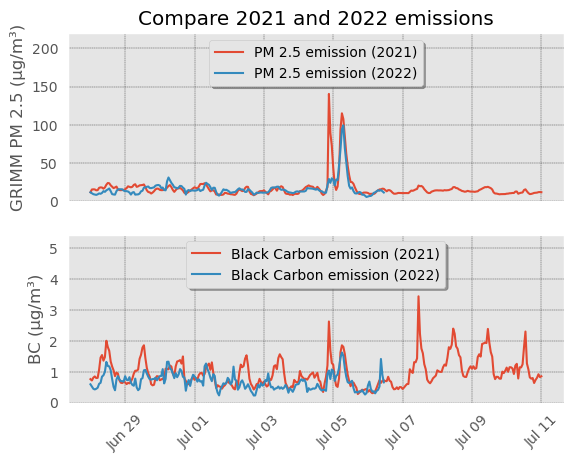

In [734]:
y_datas = [ pm25_2021_fireworks, pm25_2022_fireworks, bc_2021_fireworks, bc_2022_fireworks ]
x_datas = [ time_2021_fireworks, time_2022_fireworks, time_2021_fireworks, time_2022_fireworks ]
series_labels = [ 'PM 2.5 emission (2021)', 'PM 2.5 emission (2022)', 
                  'Black Carbon emission (2021)', 'Black Carbon emission (2022)' ]
y_labels = [ 'GRIMM PM 2.5 (µg/m³)', 'BC (µg/m³)' ]

plotting.stacked_overlay_plot(x_datas=x_datas, y_datas=y_datas, series_labels=series_labels,
                       y_labels=y_labels, title='Compare 2021 and 2022 emissions', top_paddings=[80, 2])

# Air Pollution in the Yellow Sea

The Yellow Sea is a marginal sea of the Western Pacific Ocean located between mainland China and the Korean Peninsula. It is considered among the most degraded marine areas on earth. Loss of natural coastal habitats due to land reclamation has resulted in the destruction of more than 60% of tidal wetlands around the Yellow Sea. 

Every year, China invokes sustainability to unilaterally impose a ban on fishing in the Yellow Sea, Bohai Sea, East China Sea, and the waters north of 12 degrees latitude in the South China Sea. This ban is in effect from May 1 to August 16 and is enforced by the Chinese Coast Guard.

China is one of the largest maritime states and has the largest fishery catch in the world. The large number of fishing vessels in the Yellow Sea has increased the air pollution. 

Pollution also tends to increase in the winter as an increased amount of fuel is burned.  Furthermore dense cold air traps pollutants near the surface of the earth which increases air pollution levels.

### Area of Interest

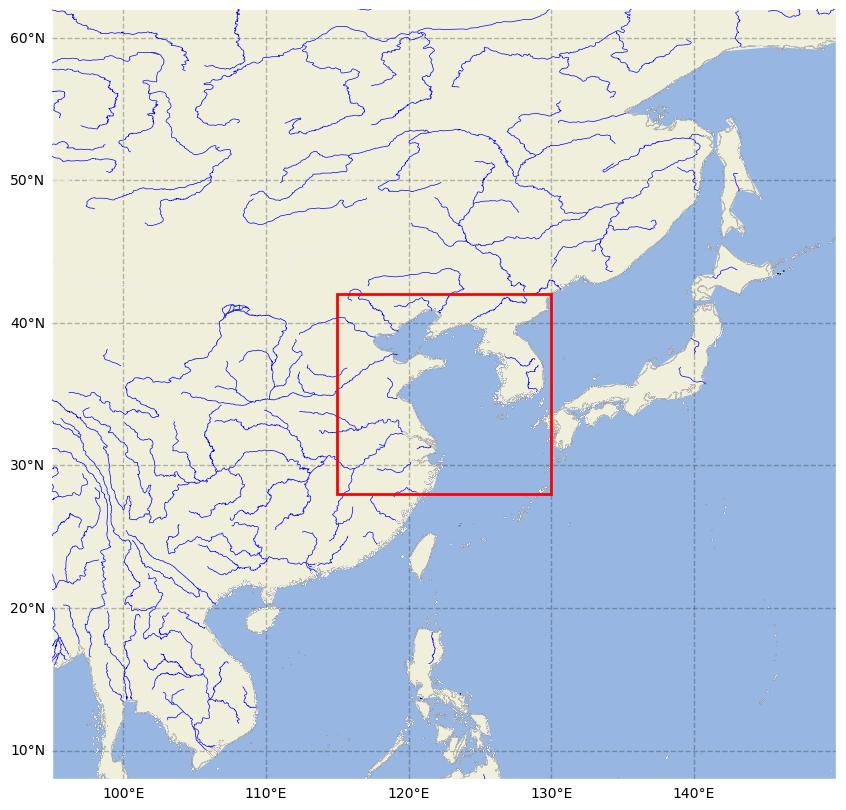

In [735]:
yellow_sea_bb = {'min_lon': 115, 'max_lon': 130, 'min_lat': 28, 'max_lat': 42}
plotting.map_box(yellow_sea_bb)

### Air Quality: May vs. February in the Yellow Sea 

The below graphs are a visualization of Aerosol Optical Depth (AOD) data. Aerosol Optical Depth is the measure of aerosols (e.g., urban haze, smoke. particles, desert dust) distributed within a column of air. 


### Generate Legend

In [ ]:
wmsUrl = 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?\
SERVICE=WMS&REQUEST=GetCapabilities'

response = requests.get(wmsUrl)
WmsTree = xmlet.fromstring(response.content)

legendImg = None
for child in WmsTree.iter():
    for layer in child.findall("./{http://www.opengis.net/wms}Capability/{http://www.opengis.net/wms}Layer//*/"): 
         if layer.tag == '{http://www.opengis.net/wms}Layer': 
            f = layer.find("{http://www.opengis.net/wms}Name")
            if f is not None:
                if f.text == "MODIS_Combined_Value_Added_AOD":
                    # Style
                    e = layer.find(("{http://www.opengis.net/wms}Style/" +
                                    "{http://www.opengis.net/wms}LegendURL/" +
                                    "{http://www.opengis.net/wms}OnlineResource"))
                    legendURL = e.attrib["{http://www.w3.org/1999/xlink}href"]
                    combinedLegendImg = Image(url=legendURL)
                    
#display(combinedLegendImg)

### May (Summer and Fishing Moratorium)

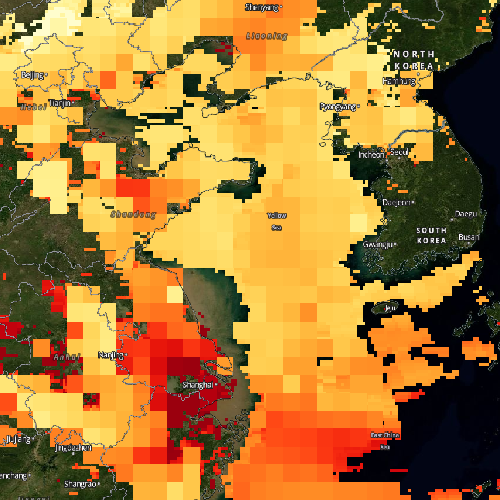

In [737]:
# Connect to GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

img = wms.getmap(layers=['BlueMarble_NextGeneration',
                         'MODIS_Terra_Aerosol', 
                         'MODIS_Aqua_Aerosol', 
                         'MODIS_Combined_Value_Added_AOD',
                         'Reference_Features',
                         'Reference_Labels'],  # Layers
                 srs='epsg:4326',  # Map projection
                 bbox=(115, 28, 130, 42),  # Bounds (min-lon, min-lat, max-lon, max-lat) -> min lon: 115.179845, min lat: 28.087158,130.209142,41.718570
                 size=(500, 500),  # Image size
                 time='2021-05-02',  # Time of data
                 format='image/png',  # Image format
                 transparent=True)  # Nodata transparency

# View image and legend
display(combinedLegendImg)
Image(img.read())

### February (Winter and Fishing Season)

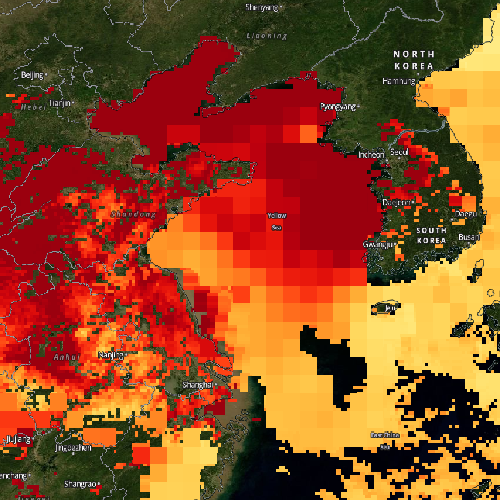

In [738]:
# Connect to GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

img = wms.getmap(layers=['BlueMarble_NextGeneration',
                         'MODIS_Terra_Aerosol',
                         'MODIS_Aqua_Aerosol', 
                         'MODIS_Combined_Value_Added_AOD',
                         'Reference_Features',
                         'Reference_Labels'],  # Layers
                 srs='epsg:4326',  # Map projection
                 bbox=(115, 28, 130, 42),  # Bounds (min-lon, min-lat, max-lon, max-lat)
                 size=(500, 500),  # Image size
                 time='2022-02-25',  # Time of data
                 format='image/png',  # Image format
                 transparent=True)  # Nodata transparency

# View image and legend
display(combinedLegendImg)
Image(img.read())

In [739]:
yellow_sea_bb = {'min_lon': 28, 'max_lon': 130, 'min_lat': 8, 'max_lat': 30}
yellow_sea_start_time = datetime(2020, 1, 1)
yellow_sea_end_time = datetime(2020, 12, 1)

https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=GMU-OMI-0.25deg-monthly-Global-NO2&minLon=28&minLat=8&maxLon=130&maxLat=30&startTime=2020-01-01T00:00:00Z&endTime=2020-12-01T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 5.964769251004327 seconds


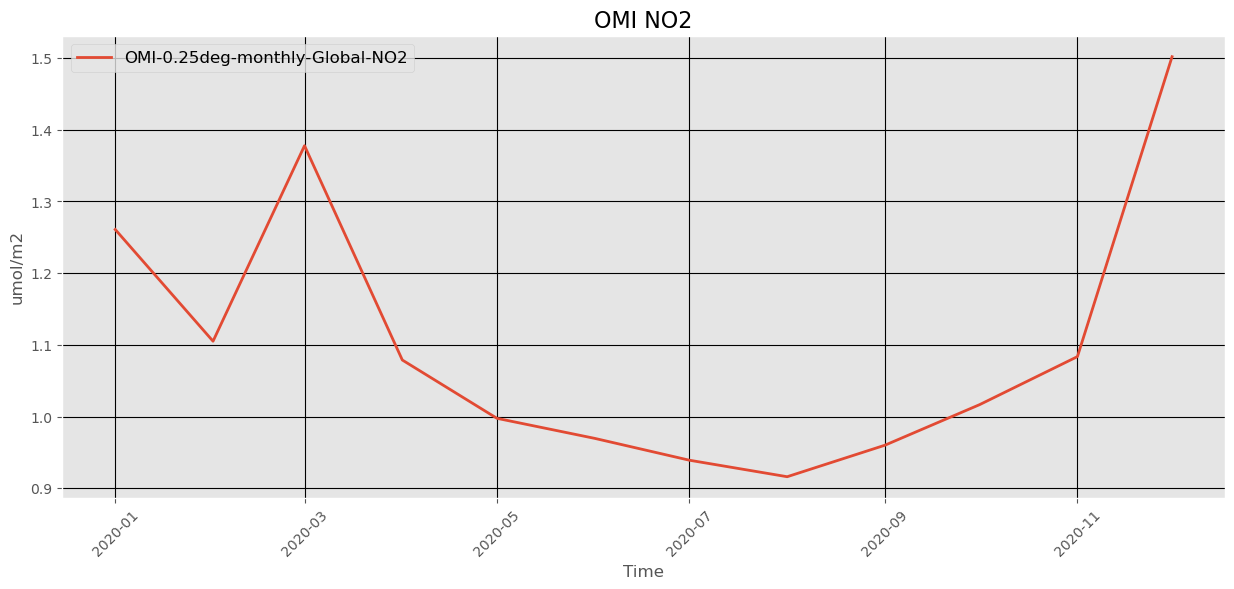

In [740]:
#NOTE: show as barchart
yellow_sea_omi_no2 = plotting.spatial_mean(aq_base_url, 'GMU-OMI-0.25deg-monthly-Global-NO2', yellow_sea_bb, yellow_sea_start_time, yellow_sea_end_time)
plotting.comparison_plot([yellow_sea_omi_no2], 'Time', units['NO2'], var='OMI NO2')

# Fires and Thermal Anomalies in Southeast Asia (2022 Fire Season)
Fire season typically runs from February to April each year and is characterized by high temperatures, dry weather, and widespread agricultural burning.  

### Area of Interest

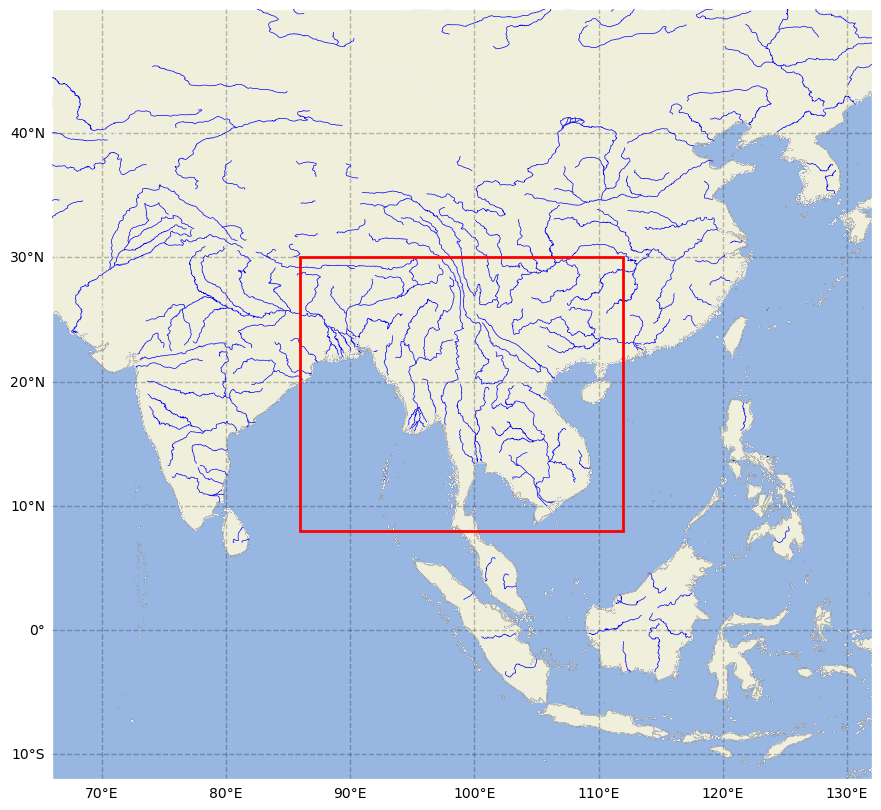

In [741]:
anomalies_start_time = datetime(2020, 1, 1)
anomalies_end_time = datetime(2020, 12, 1)

anomalies_bb = {'min_lon': 86, 'max_lon': 112, 'min_lat': 8, 'max_lat': 30}
plotting.map_box(anomalies_bb)

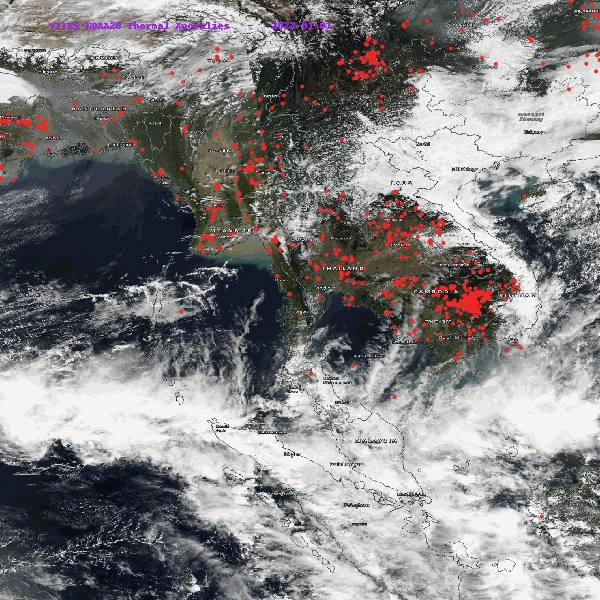

In [742]:
# Note takes ~20s to generate
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

layers=['VIIRS_NOAA20_CorrectedReflectance_TrueColor', 
        'VIIRS_NOAA20_Thermal_Anomalies_375m_All',
        'Reference_Features',
        'Reference_Labels']
color = 'rgb(160, 32, 240)'
frames = []

sdate = datetime(2022, 1, 1)
edate = datetime(2022, 4, 1)
dates = pd.date_range(sdate,edate,freq='MS') 

for day in dates:
    datatime = day.strftime("%Y-%m-%d")
    img = wms.getmap(layers=layers,  # Layers
                     srs='epsg:4326',  # Map projection
                     bbox=(86, -5, 112, 31), # Bounds
                     size=(600,600),  # Image size
                     time=datatime,  # Time of data
                     format='image/png',  # Image format
                     transparent=True)  # Nodata transparency

    image = I.open(img)
    draw = ImageDraw.Draw(image)
    (x, y) = (50, 20)
    draw.text((x, y), f'VIIRS NOAA20 Thermal Anomalies   -   {datatime}', fill=color) # NOTE make bigger, look for better colors 
    frames.append(image)
    
frames[0].save('VIIRS_NOAA20_Thermal_Anomalies_375m_All.gif',
               format='GIF',
               append_images=frames,
               save_all=True,
               duration=1000,
               loop=0)

Image('VIIRS_NOAA20_Thermal_Anomalies_375m_All.gif')

https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=GMU-OMI-0.25deg-monthly-Global-NO2&minLon=86&minLat=8&maxLon=112&maxLat=30&startTime=2020-01-01T00:00:00Z&endTime=2020-12-01T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 2.705497117996856 seconds


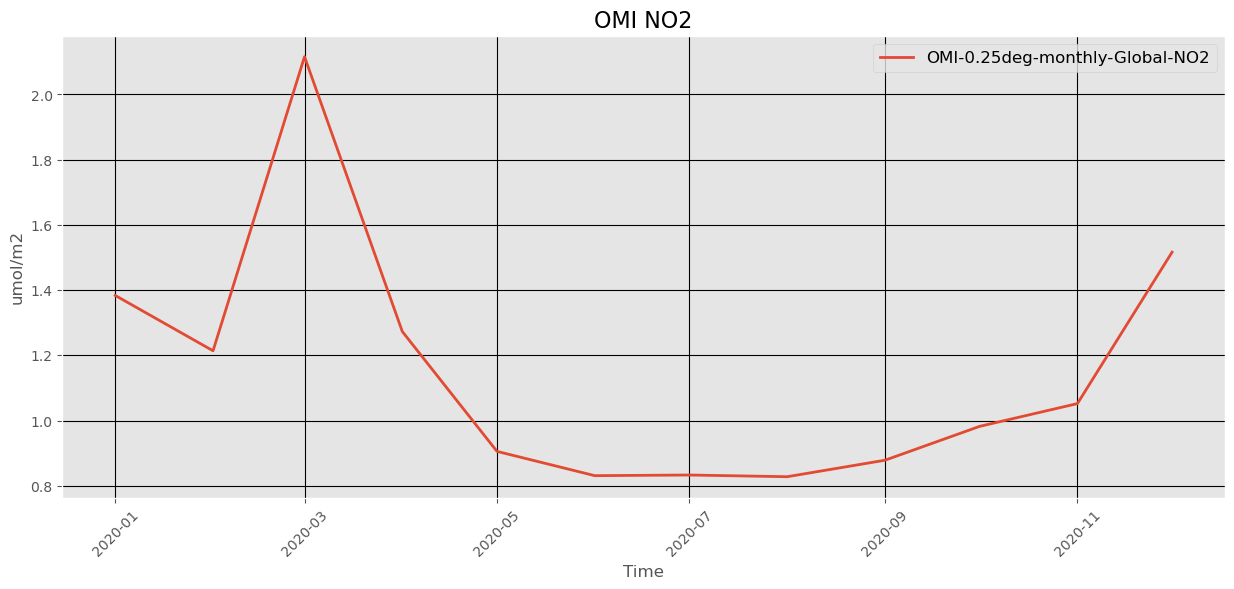

In [743]:
#NOTE: show as barchart
anomalies_no2 = plotting.spatial_mean(aq_base_url, 'GMU-OMI-0.25deg-monthly-Global-NO2', anomalies_bb, anomalies_start_time, anomalies_end_time)
plotting.comparison_plot([anomalies_no2], 'Time', units['NO2'], var='OMI NO2')